<a href="https://colab.research.google.com/github/deniseiras/BAM1D-Microphysics-Emulation/blob/main/BAM1D_Physics_Emulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BAM1D Physics Emulation

<font size="5">**Objetivo:** Emular a Hugh Morrison Microphysics implementada em BAM1D</font>
 


SUBROUTINE RunMicro_HugMorr(  
  
**ncols** - numero de colunas - fixo = 1  
nCols       , &!INTEGER      , INTENT(IN   ) :: nCols

**kmax** - número de níveis = 28  
kMax        , &!INTEGER      , INTENT(IN   ) :: kMax 

**si** - kmax+1 removido, sem valores/usado
si          , &!REAL(KIND=r8), INTENT(IN   ) :: si(kMax+1)

**sl**  
sl          , &!REAL(KIND=r8), INTENT(IN   ) :: sl(kMax)

**tc** - Temperature(K)  
tc          , &!REAL(KIND=r8), INTENT(INOUT) :: Tc (1:nCols, 1:kMax)

<font size="5">Q's - Mixing ratio </font>

**QV** - water vapor  
QV          , &!REAL(KIND=r8), INTENT(INOUT) :: qv (1:nCols, 1:kMax)

**QC** - cloud water  
QC          , &!REAL(KIND=r8), INTENT(INOUT) :: qc (1:nCols, 1:kMax)

**QR**  - rain water  
QR          , &!REAL(KIND=r8), INTENT(INOUT) :: qr (1:nCols, 1:kMax)

**QI** - cloud ice  
QI          , &!REAL(KIND=r8), INTENT(INOUT) :: qi (1:nCols, 1:kMax)

**QS** - Snow  
QS          , &!REAL(KIND=r8), INTENT(INOUT) :: qs (1:nCols, 1:kMax)

**QG** - Graupel  
QG          , &!REAL(KIND=r8), INTENT(INOUT) :: qg (1:nCols, 1:kMax)

<font size="5">*N's* - number concentration
</font>  

**NI** - cloud ice  
NI          , &!REAL(KIND=r8), INTENT(INOUT) :: ni (1:nCols, 1:kMax)

**NS** - Snow  
NS          , &!REAL(KIND=r8), INTENT(INOUT) :: ns (1:nCols, 1:kMax)

**NR** - Rain    
NR          , &!REAL(KIND=r8), INTENT(INOUT) :: nr (1:nCols, 1:kMax)

**NG** - Graupel  
NG          , &!REAL(KIND=r8), INTENT(INOUT) :: NG (1:nCols, 1:kMax)   

**NC** - Cloud droplet  
NC          , &!REAL(KIND=r8), INTENT(INOUT) :: NC (1:nCols, 1:kMax)   

**TKE** - turbulence kinetic energy (m^2 s-2), NEEDED FOR DROPLET ACTIVATION  
TKE         , &!REAL(KIND=r8), INTENT(IN   ) :: TKE (1:nCols, 1:kMax)   

**KZH** -  heat eddy diffusion coefficient from YSU scheme (M^2 S-1), NEEDED FOR DROPLET ACTIVATION  
KZH         , &!REAL(KIND=r8), INTENT(IN   ) :: KZH (1:nCols, 1:kMax)   

**gps** - Pressão - removida da entrada da RNA - valor fixo  
gps         , &!gps- AIR PRESSURE (PA)

**DT_IN** - model time step (sec) - Removido da entrada da RNA
DT_IN       , &!REAL(KIND=r8), INTENT(IN   ) :: dt_in

**omega**  
omega       , &!REAL(KIND=r8), INTENT(IN   ) :: omega  ! omega (Pa/s)

**EFFCS** - CLOUD DROPLET EFFECTIVE RADIUS OUTPUT TO RADIATION CODE (micron)  
EFFCS       , &!REAL(KIND=r8), INTENT(OUT  ) :: EFFCS (1:nCols, 1:kMax)   

**EFFIS** - CLOUD DROPLET EFFECTIVE RADIUS OUTPUT TO RADIATION CODE (micron)  
EFFIS       , &!REAL(KIND=r8), INTENT(OUT  ) :: EFFIS (1:nCols, 1:kMax)   

**LSRAIN** - Large scale Rain  
LSRAIN      , &!REAL(KIND=r8), INTENT(OUT) :: LSRAIN(1:nCols)

**LSSNOW** - Large scale Snow  
LSSNOW        )!REAL(KIND=r8), INTENT(OUT) :: LSSNOW(1:nCols)


# Setup do dados

Carregamento dos dados

In [ ]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import time
from sklearn import metrics

# %tensorflow_version 1.x

import tensorflow as tf
import keras
from tensorflow.python.data import Dataset

from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout
from keras.utils.vis_utils import plot_model
from keras.callbacks import TensorBoard


from datetime import datetime
from shutil import copyfile, copytree, rmtree

# tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
# pd.options.display.float_format = '{:.1f}'.format
pd.options.display.float_format = '{:f}'.format


# working local
#
# %load_ext tensorboard funciona local ???
# %reload_ext tensorboard ???
# original_input_df = pd.read_csv("/home/denis/_COM_BACKUP/bam1d_physics_nn/hug_morr_inputs.csv", sep=",")
# original_output_df = pd.read_csv("/home/denis/_COM_BACKUP/bam1d_physics_nn/hug_morr_outputs.csv", sep=",")
# tb_logdir_base = '/home/denis/_COM_BACKUP/bam1d_physics_nn/logs/'

# loading manually at each run
#
# import io
# from google.colab import files
# uploaded = files.upload()
# original_input_df = pd.read_csv(io.StringIO(uploaded['hug_morr_inputs.csv'].decode('utf-8')), sep=",")
# original_output_df = pd.read_csv(io.StringIO(uploaded['hug_morr_outputs.csv'].decode('utf-8')), sep=",")

# loading from gdrive
#
from google.colab import drive
drive.mount('/content/drive')
colab_in_drive_root_dir = "/content/drive/My Drive/Colab Notebooks/"
original_input_df = pd.read_csv("{}/hug_morr_inputs.csv".format(colab_in_drive_root_dir), sep=",")
original_output_df = pd.read_csv("{}/hug_morr_outputs.csv".format(colab_in_drive_root_dir), sep=",")
tb_logdir_base = './logs'

# generate random lines - problems due to k_vars
# input_df = original_input_df.reindex(np.random.permutation(original_input_df.index))
# output_df = original_output_df.reindex(np.random.permutation(original_output_df.index))


Mounted at /content/drive


## Análise dos dados

### Análise estatística

- Resumo dos valores das variáveis de entrada e saída. Observe que os valores são truncados no Resumo
- Valores do primeiro, centésimo e último passo de tempo
- Níveis verticais do primeiro, centésimo e último passo de tempo

In [ ]:
print("\nAll input summary:")
display.display(original_input_df.describe())
print("\nAll output summary:")
display.display(original_output_df.describe())


print("\nInput First timestep:")
display.display(original_input_df.head(28))
print("\nInput 100th timestep:")
display.display(original_input_df.loc[2800:2800+27])
print("\nInput Last timestep:")
display.display(original_input_df.tail(28))

print("\nOutput First timestep:")
display.display(original_output_df.head(28))
print("\nOutput 100th timestep:")
display.display(original_output_df.loc[2800:2800+27])
print("\nOutput Last timestep:")
display.display(original_output_df.tail(28))





All input summary:


,k,si,si_kmax_+_1,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,gps,omega
count,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000
mean,14.500000,0.468551,0.000000,0.450519,240.921717,0.005842,0.000002,0.000001,0.000001,0.000030,0.000000,61165.494411,1043501.113801,4576.122062,0.001798,121900.322353,0.270647,28.647202,99000.000000,-0.031886
std,8.077762,0.363561,0.000000,0.361059,57.643654,0.006346,0.000016,0.000009,0.000006,0.000084,0.000000,278606.717186,3399577.554376,51098.109604,0.111052,980184.883186,1.144277,78.850032,0.000000,0.124607
min,1.000000,0.003669,0.000000,0.001523,76.927183,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,99000.000000,-1.040423
25%,7.750000,0.103880,0.000000,0.090635,199.164832,0.000047,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,-0.032514
50%,14.500000,0.432240,0.000000,0.399916,260.250033,0.002262,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.682792,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
75%,21.250000,0.834470,0.000000,0.811268,290.003008,0.012095,0.000000,0.000000,0.000000,0.000014,0.000000,0.000000,42529.564205,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.013516
max,28.000000,1.000000,0.000000,0.994964,310.312954,0.016855,0.000493,0.000329,0.000115,0.001189,0.000000,1744027.026220,22604778.815400,1740941.655300,21.011023,22999124.957800,6.000000,300.000000,99000.000000,0.240343



All output summary:


,k,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
count,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000
mean,14.500000,240.923603,0.005841,0.000002,0.000001,0.000001,0.000030,0.000000,61176.006687,1043612.390624,4576.122062,0.001798,121900.322353,24.592588,28.428168,0.000000,0.000000
std,8.077762,57.638340,0.006348,0.000016,0.000009,0.000006,0.000084,0.000000,278629.584989,3399730.114834,51098.109604,0.111052,980184.883186,2.521517,14.624718,0.000002,0.000000
min,1.000000,76.927183,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,-0.000000,0.000000
25%,7.750000,199.163220,0.000036,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
50%,14.500000,260.397331,0.002386,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.691543,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
75%,21.250000,289.996409,0.012101,0.000000,0.000000,0.000000,0.000014,0.000000,0.000000,42531.493798,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
max,28.000000,310.312954,0.016964,0.000493,0.000329,0.000115,0.001189,0.000000,1744027.026220,22604778.815400,1740941.655300,21.011023,22999124.957800,27.606963,130.000000,0.000034,0.000000



Input First timestep:


,k,si,si_kmax_+_1,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,gps,omega
0,1,1.000000,0.000000,0.994964,294.178437,0.016781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.695110,99000.000000,-0.000992
1,2,0.989934,0.000000,0.981964,294.000352,0.016364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.680441,99000.000000,-0.000187
2,3,0.974009,0.000000,0.964137,293.731351,0.015746,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.001870
3,4,0.954290,0.000000,0.942167,293.174866,0.015051,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.002775
4,5,0.930081,0.000000,0.915361,292.082711,0.014417,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,-0.001486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,24,0.042912,0.000000,0.035429,206.522315,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
24,25,0.028306,0.000000,0.022285,211.657434,0.000024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
25,26,0.016629,0.000000,0.011763,214.615690,0.000047,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
26,27,0.007338,0.000000,0.005429,215.728153,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000



Input 100th timestep:


,k,si,si_kmax_+_1,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,gps,omega
2800,1,1.000000,0.000000,0.994964,298.932034,0.016781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.783230,0.000000,0.000000,0.000000,5.942456,99000.000000,0.005799
2801,2,0.989934,0.000000,0.981964,297.683772,0.016364,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,13.199738,0.000000,0.000000,0.112661,14.177284,99000.000000,0.014684
2802,3,0.974009,0.000000,0.964137,295.962310,0.015746,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,23.761218,0.000000,0.000000,0.172518,9.592541,99000.000000,0.027000
2803,4,0.954290,0.000000,0.942167,294.081629,0.015051,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,64.334742,0.000000,0.000000,0.038173,5.716471,99000.000000,0.040628
2804,5,0.930081,0.000000,0.915361,292.862025,0.014417,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,276.518560,0.000000,0.000000,0.000000,0.920201,99000.000000,0.053077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2823,24,0.042912,0.000000,0.035429,206.515351,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
2824,25,0.028306,0.000000,0.022285,210.988762,0.000024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
2825,26,0.016629,0.000000,0.011763,203.719782,0.000047,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
2826,27,0.007338,0.000000,0.005429,204.470623,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000



Input Last timestep:


,k,si,si_kmax_+_1,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,gps,omega
265440,1,1.000000,0.000000,0.994964,304.673072,0.016781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.162274,99000.000000,-0.000728
265441,2,0.989934,0.000000,0.981964,303.636675,0.016364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.584893,99000.000000,0.001025
265442,3,0.974009,0.000000,0.964137,302.159501,0.015746,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.422692,30.064203,99000.000000,0.002903
265443,4,0.954290,0.000000,0.942167,300.312571,0.015051,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.032102,99000.000000,0.001065
265444,5,0.930081,0.000000,0.915361,298.005720,0.014417,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,-0.009210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265463,24,0.042912,0.000000,0.035429,186.593833,0.000003,0.000000,0.000000,0.000001,0.000049,0.000000,58817.619598,3345402.281040,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
265464,25,0.028306,0.000000,0.022285,166.784205,0.000024,0.000000,0.000000,0.000009,0.000091,0.000000,1334619.474820,9456286.900340,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
265465,26,0.016629,0.000000,0.011763,138.926510,0.000047,0.000000,0.000000,0.000000,0.000073,0.000000,0.000000,15370294.399400,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
265466,27,0.007338,0.000000,0.005429,114.091405,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,300.000000,99000.000000,0.000000



Output First timestep:


,k,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
0,1,294.639907,0.016589,0.000181,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6677692.206590,20.267474,25.000000,0.000001,0.000000
1,2,294.138620,0.016306,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6762603.595160,13.678777,25.000000,0.000001,0.000000
2,3,293.731351,0.015746,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000001,0.000000
3,4,293.174866,0.015051,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000001,0.000000
4,5,292.082711,0.014417,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,24,206.522315,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000001,0.000000
24,25,211.657434,0.000024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000001,0.000000
25,26,214.615690,0.000047,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000001,0.000000
26,27,215.728153,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000001,0.000000



Output 100th timestep:


,k,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
2800,1,298.930861,0.016782,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,13.137133,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
2801,2,297.682241,0.016364,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,18.629478,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
2802,3,295.960340,0.015747,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,34.481010,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
2803,4,294.078600,0.015052,0.000000,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,91.832575,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
2804,5,292.853591,0.014420,0.000000,0.000006,0.000000,0.000000,0.000000,0.000000,0.000000,381.136069,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2823,24,206.515351,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
2824,25,210.988762,0.000024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
2825,26,203.719782,0.000047,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
2826,27,204.470623,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000



Output Last timestep:


,k,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
265440,1,304.673072,0.016781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
265441,2,303.636675,0.016364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
265442,3,302.159501,0.015746,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
265443,4,300.312571,0.015051,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
265444,5,298.005720,0.014417,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265463,24,186.572133,0.000010,0.000000,0.000000,0.000001,0.000049,0.000000,58843.539750,3344665.313110,0.000000,0.000000,0.000000,25.000000,36.184921,0.000000,0.000000
265464,25,166.808175,0.000016,0.000000,0.000000,0.000009,0.000091,0.000000,1344231.263890,9457125.711490,0.000000,0.000000,0.000000,25.000000,24.337390,0.000000,0.000000
265465,26,138.980615,0.000030,0.000000,0.000000,0.000000,0.000073,0.000000,0.000000,15350885.696800,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
265466,27,114.091405,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000


### Histogramas das variáveis de entrada

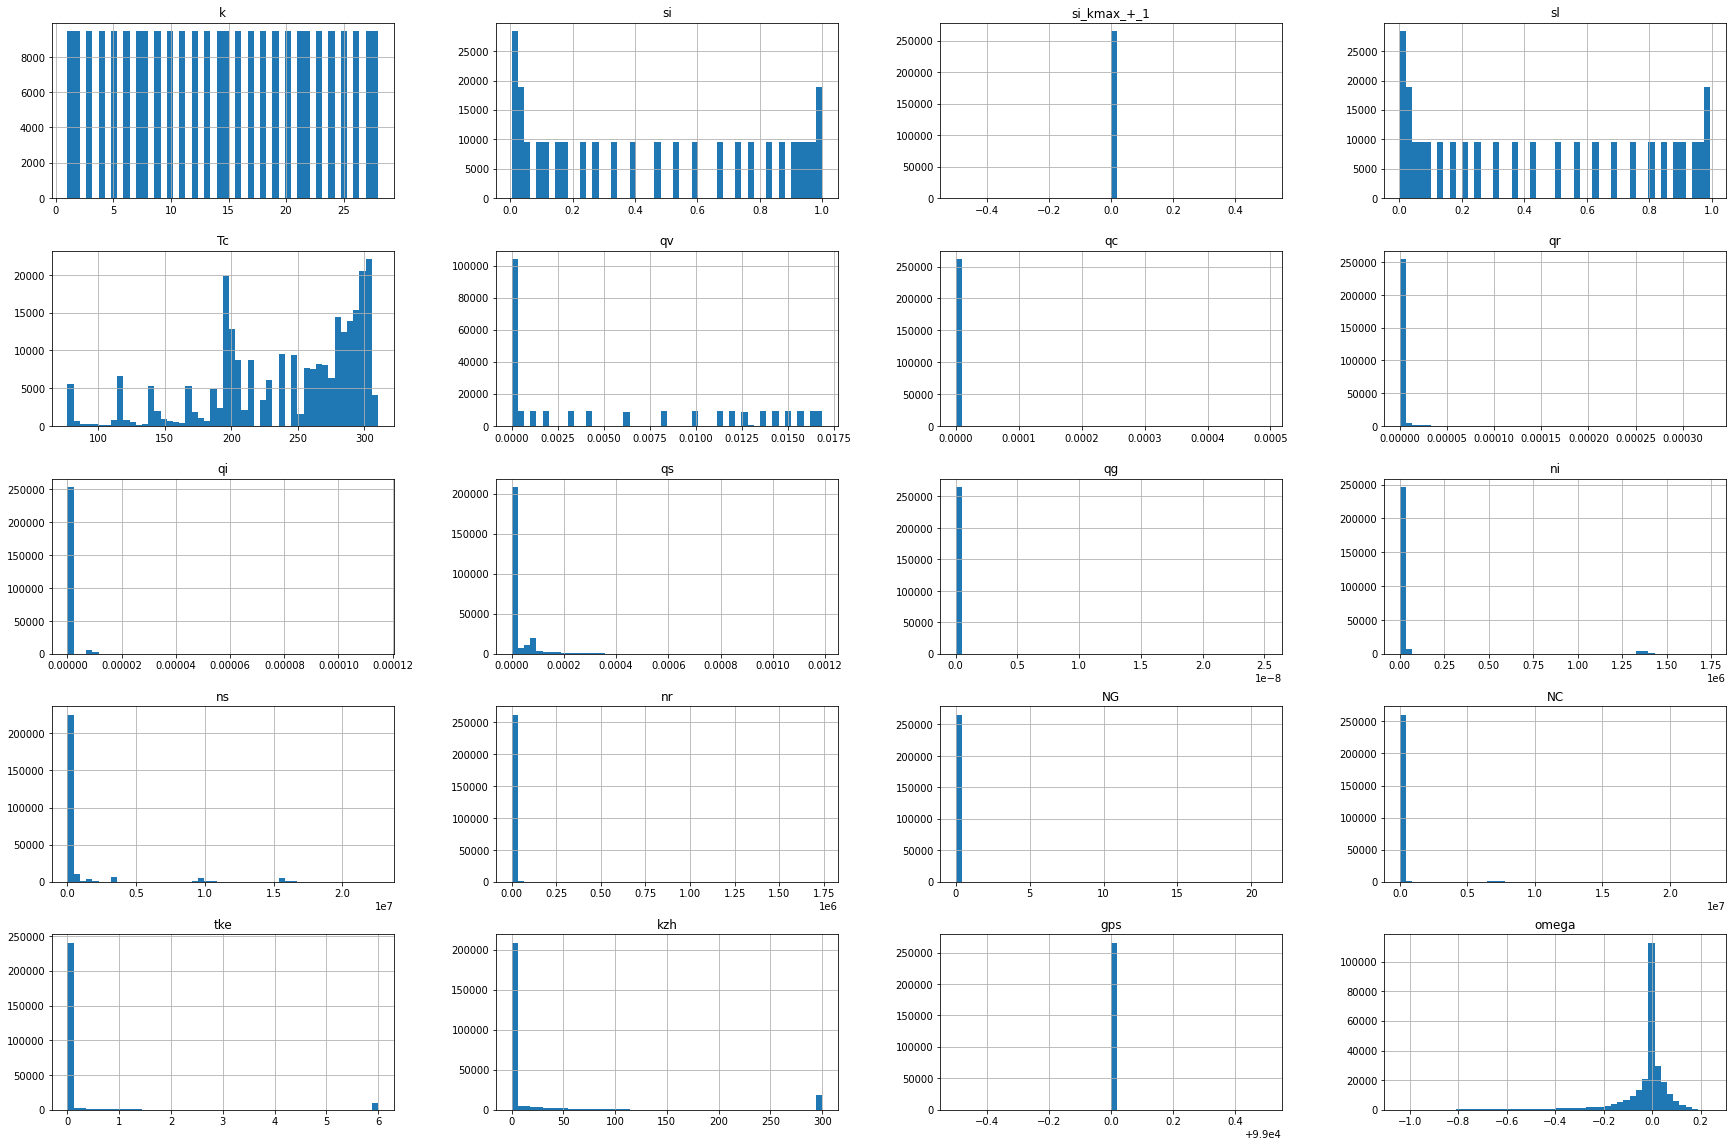

In [ ]:
# Input Histograms

# _ = original_input_df.hist(bins=50, figsize=(30, 20), xlabelsize=10)

### Histogramas das variáveis de saída

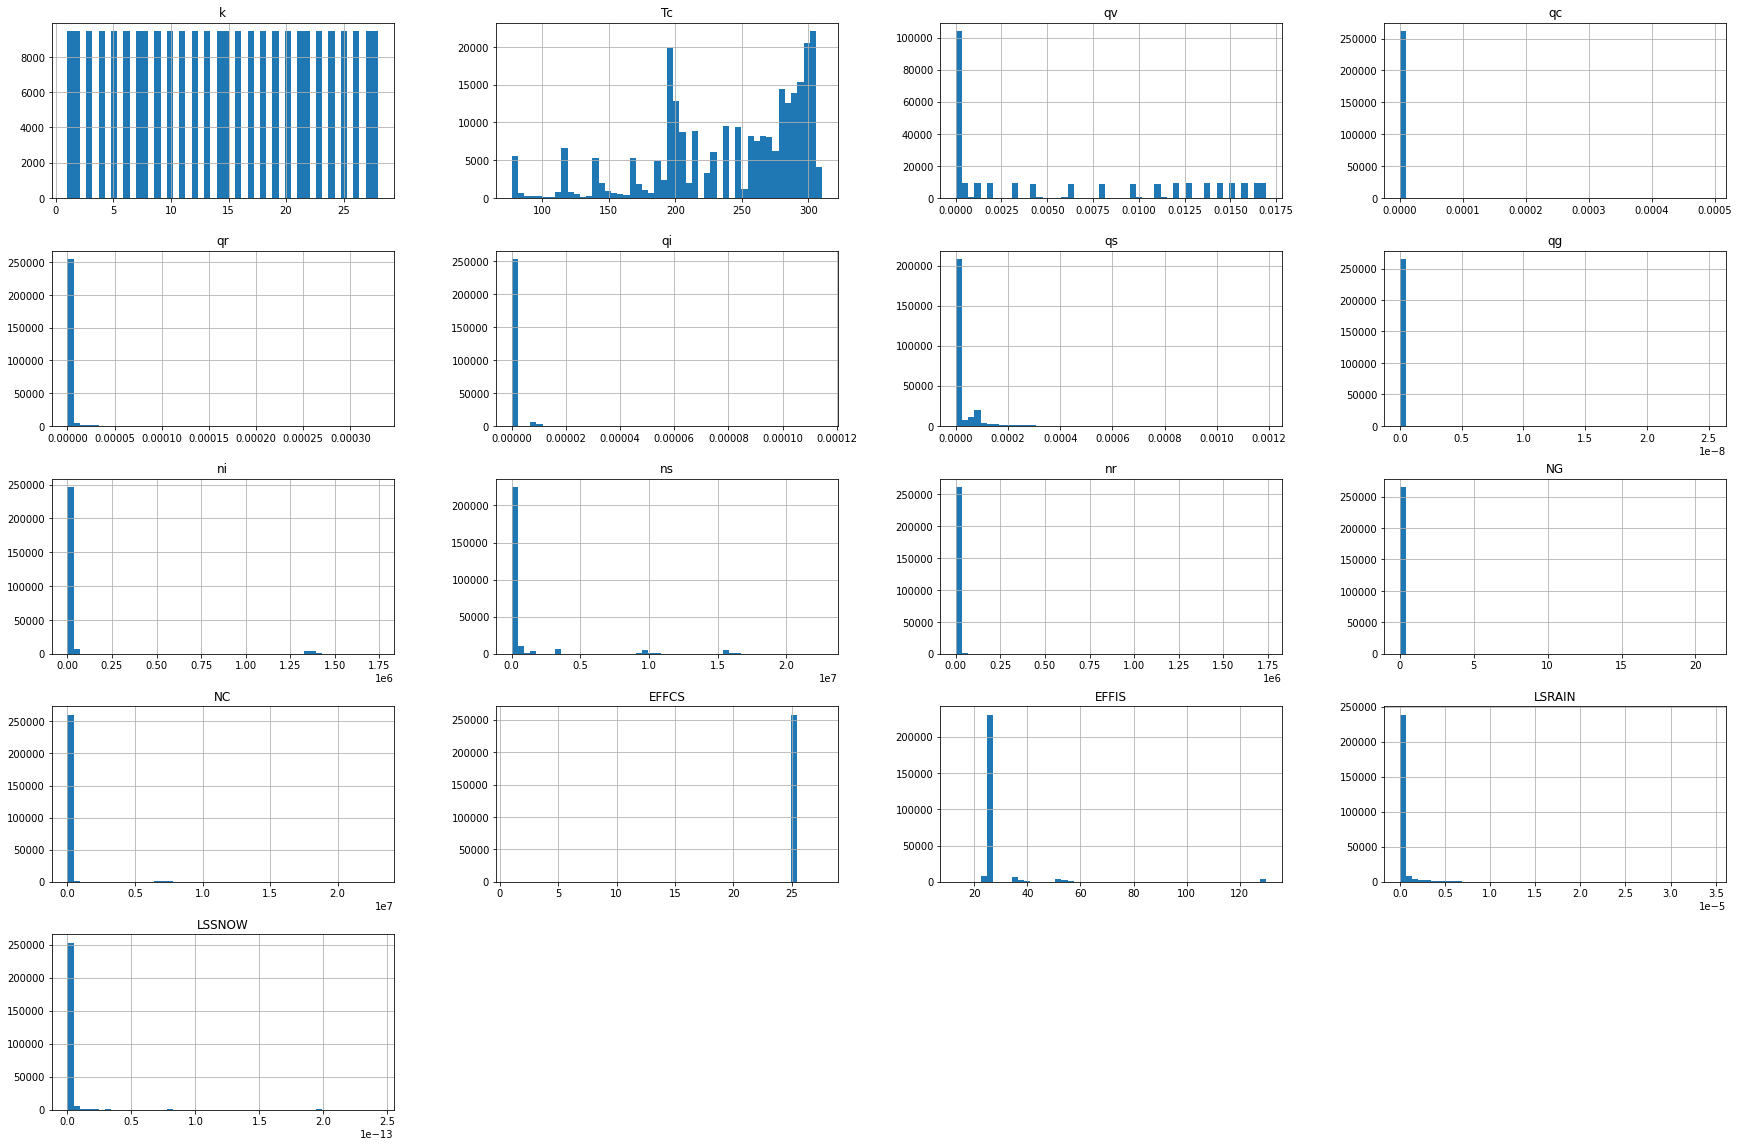

In [ ]:
# Output Histograms

# _ = original_output_df.hist(bins=50, figsize=(30, 20), xlabelsize=10)
#_ = validation_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10)

### Bloxpot das variáveis de entrada por níveis

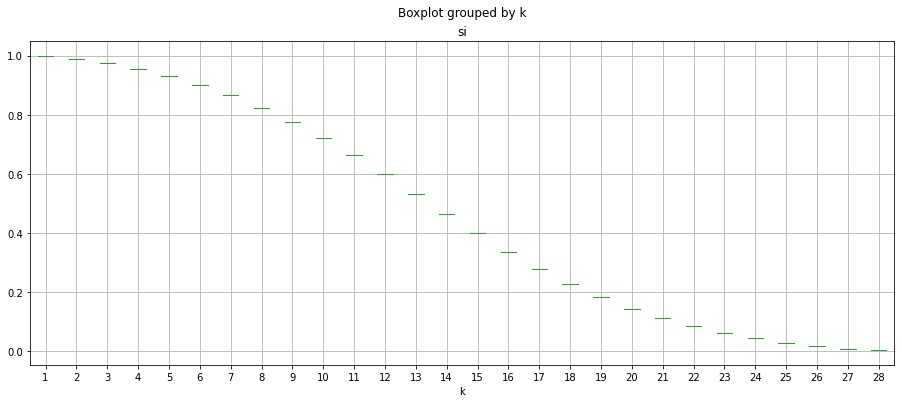

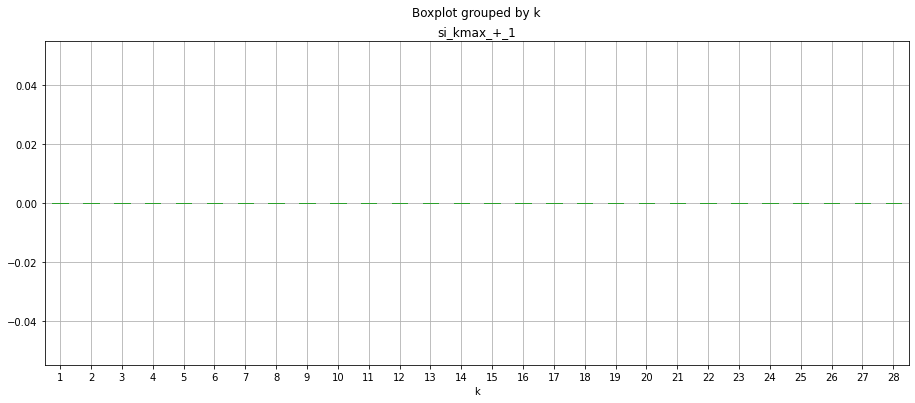

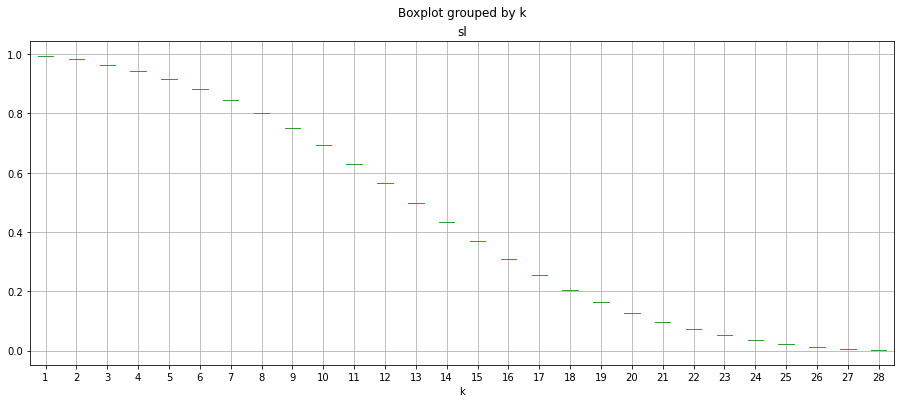

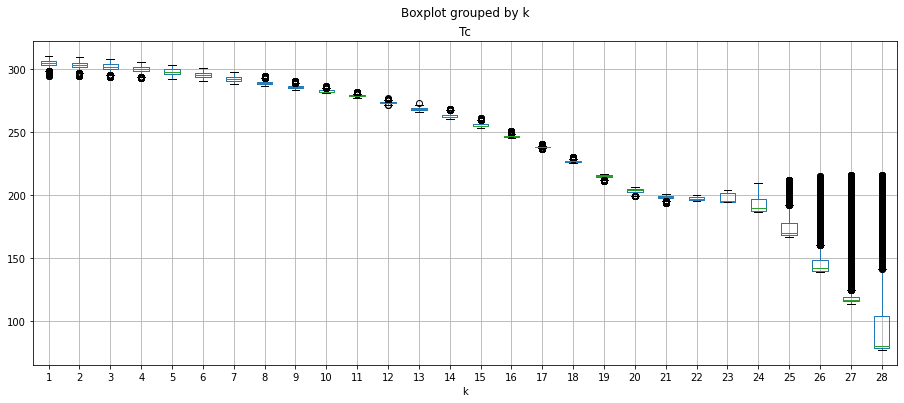

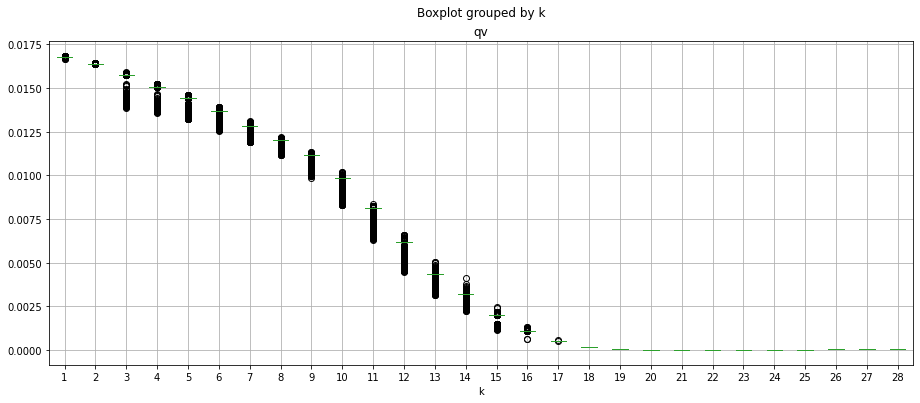

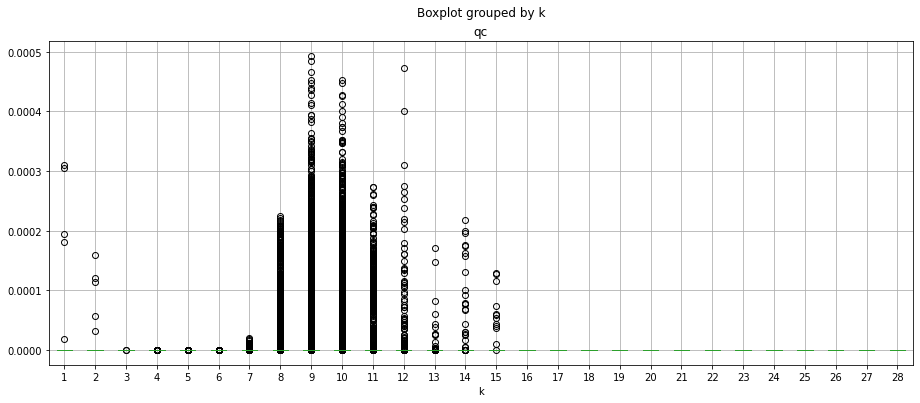

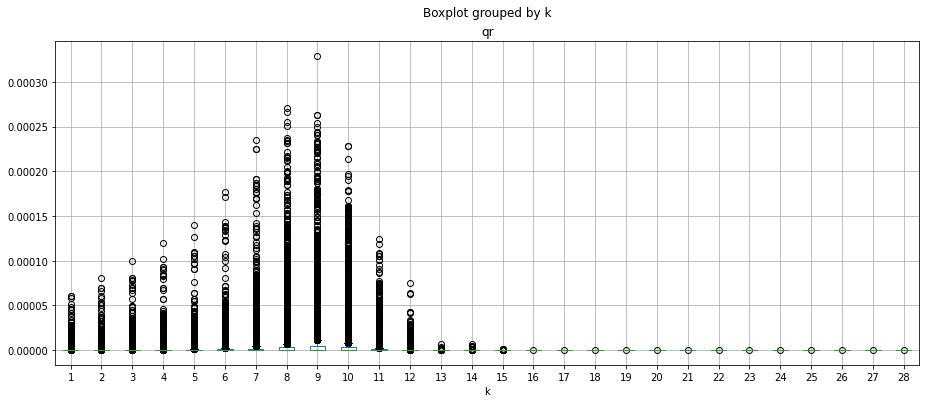

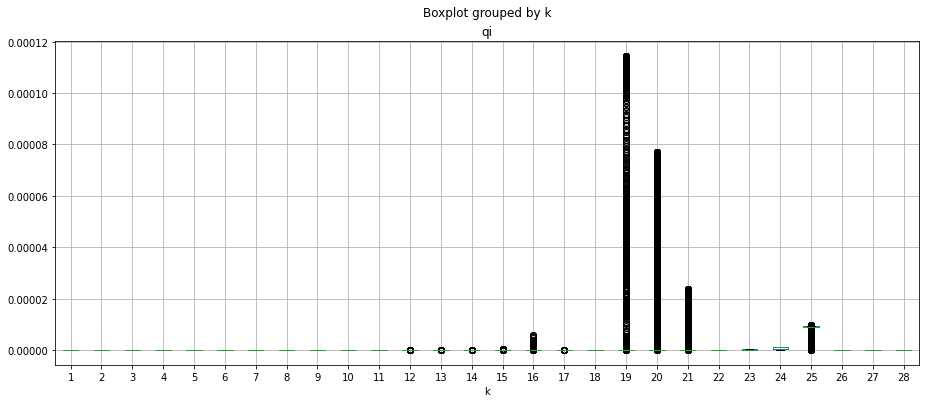

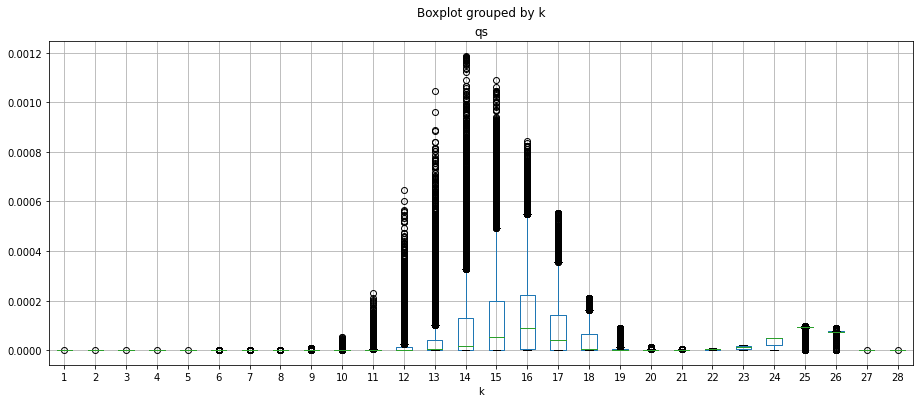

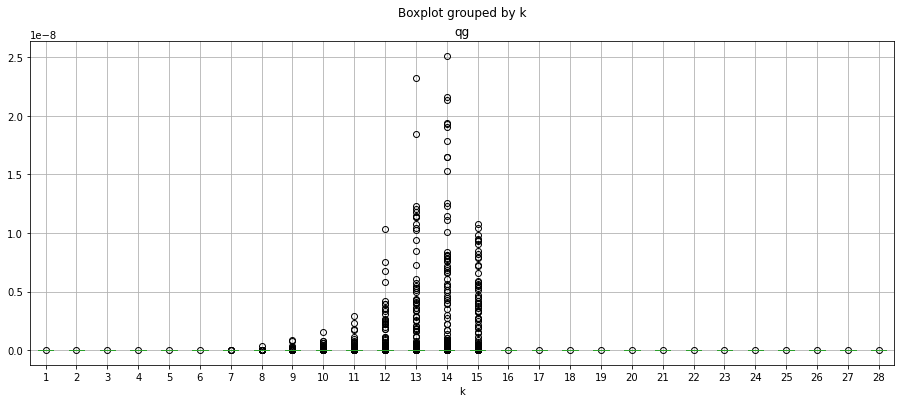

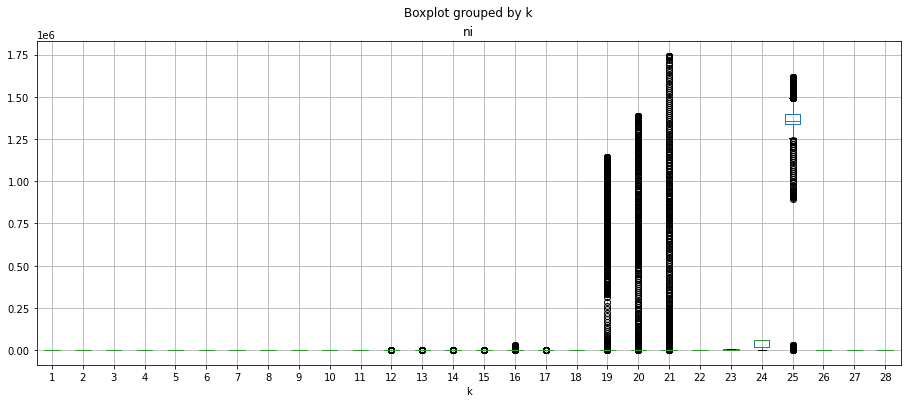

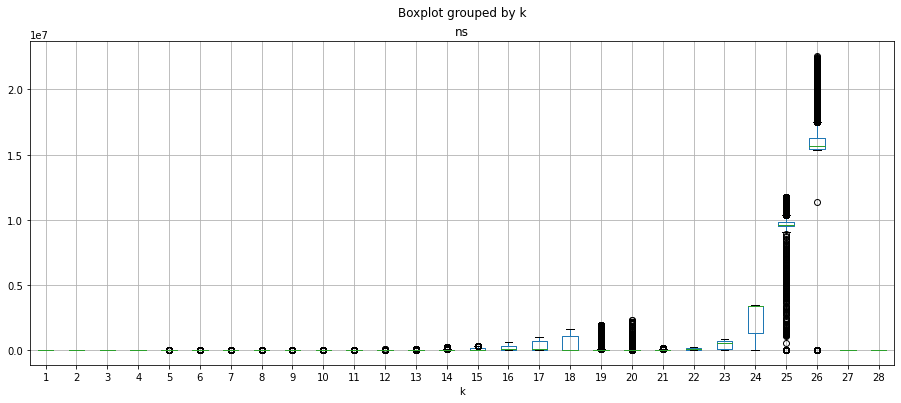

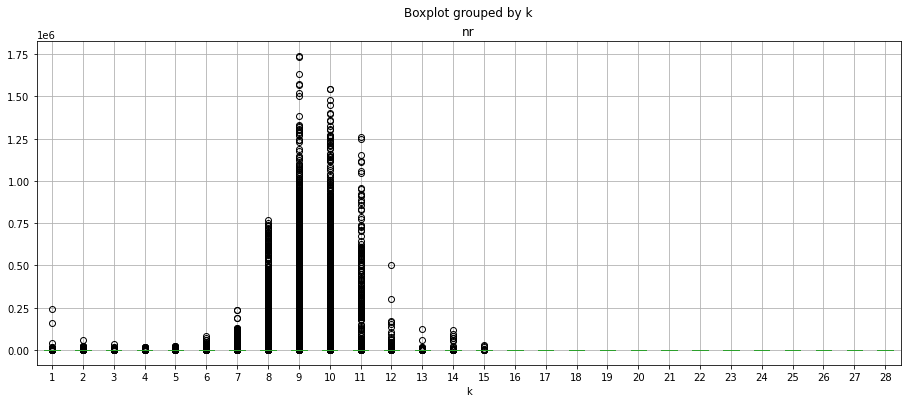

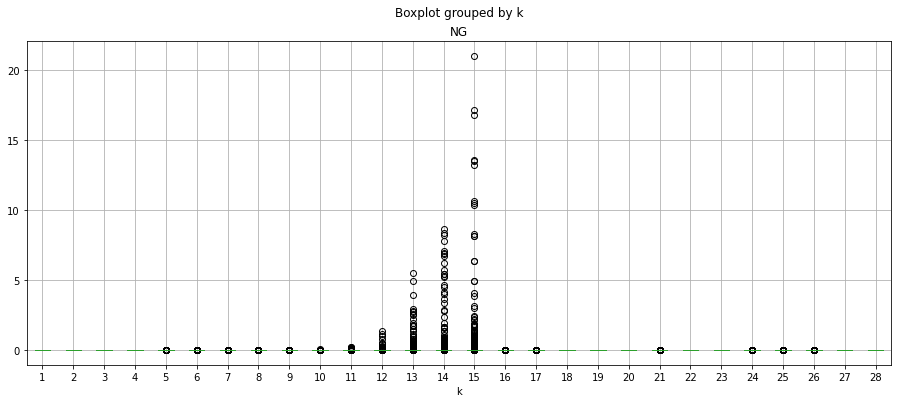

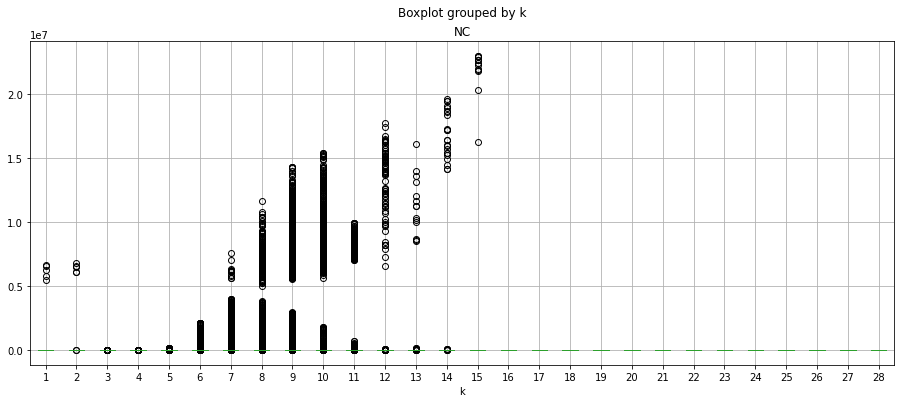

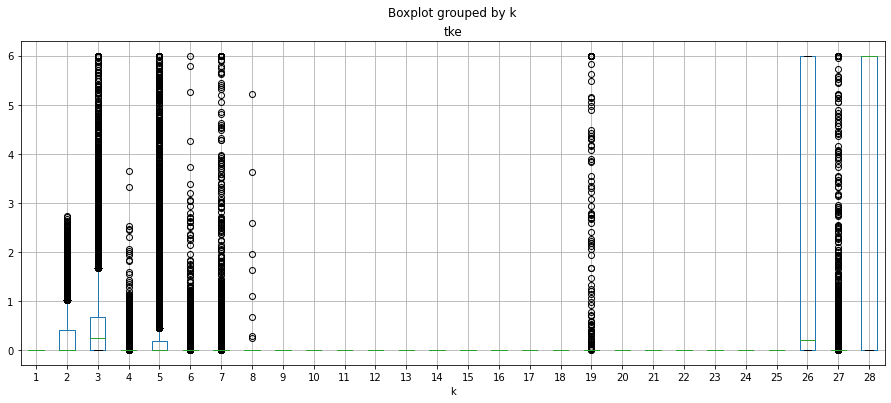

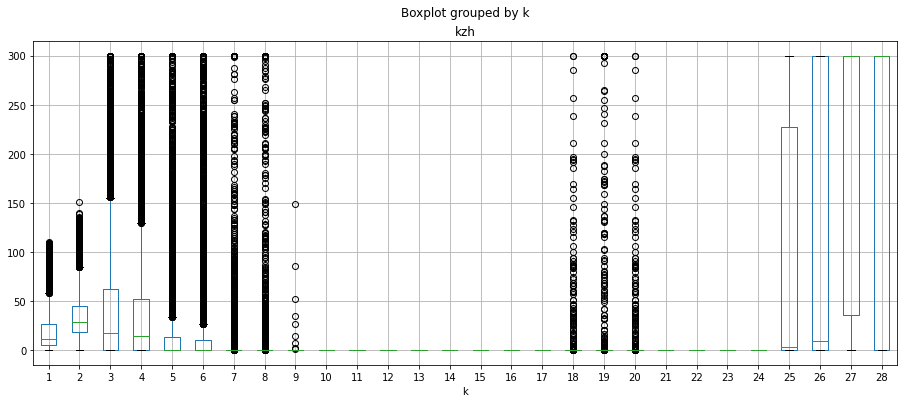

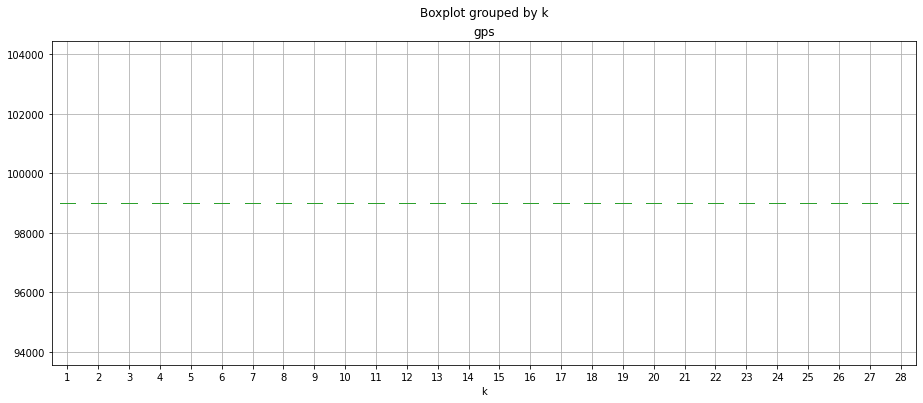

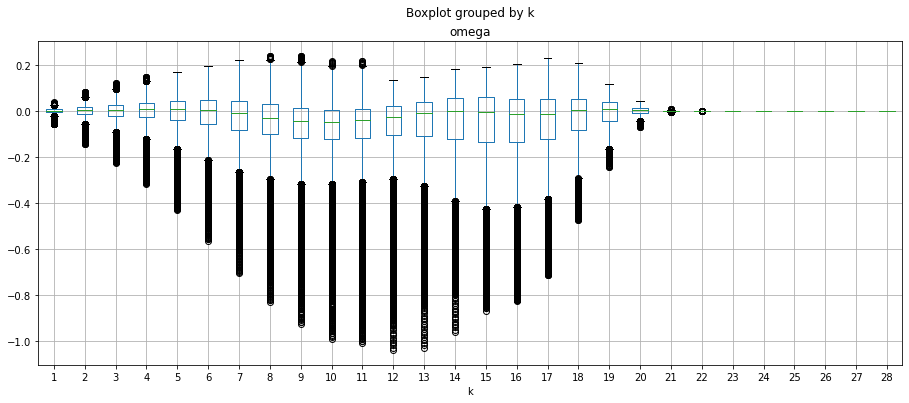

In [ ]:
# Boxplot of variables through levels

# for key in original_input_df.columns.tolist():
#     if key == "k": continue
#     # plt.subplot(6, 2, idx_plot)
#     original_input_df.boxplot(column=key, by="k", figsize=(15, 6))
# plt.show()


### Boxplot das variáveis de saída, por níveis

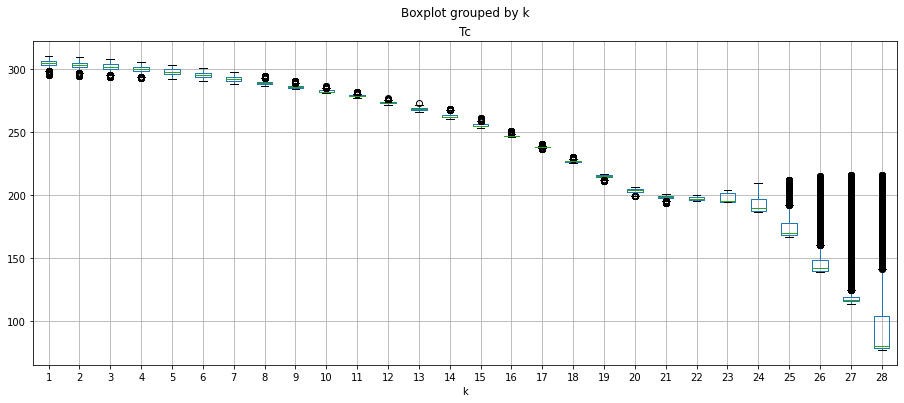

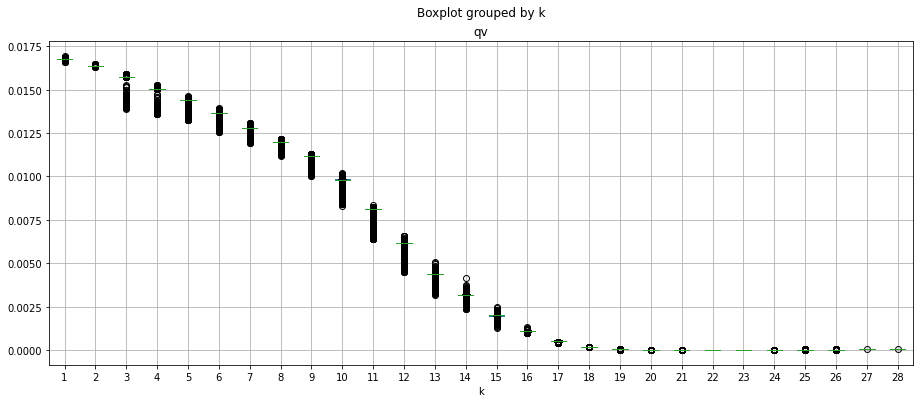

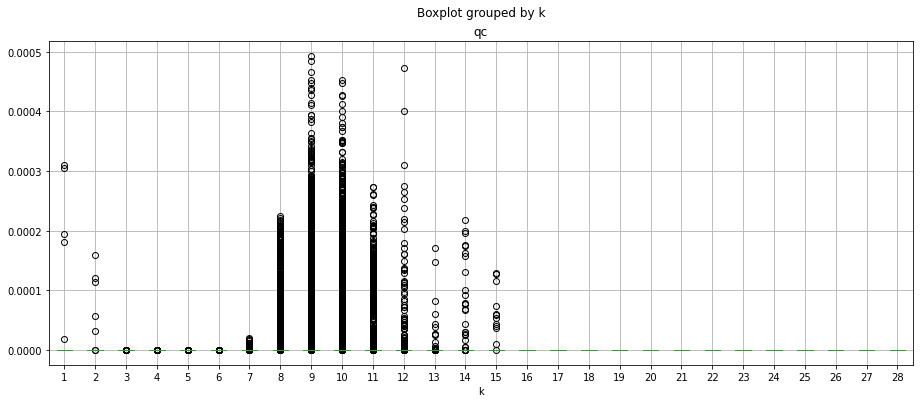

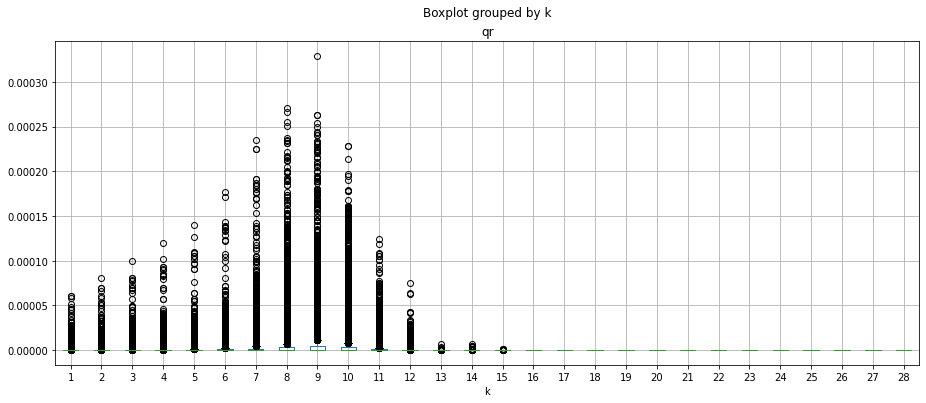

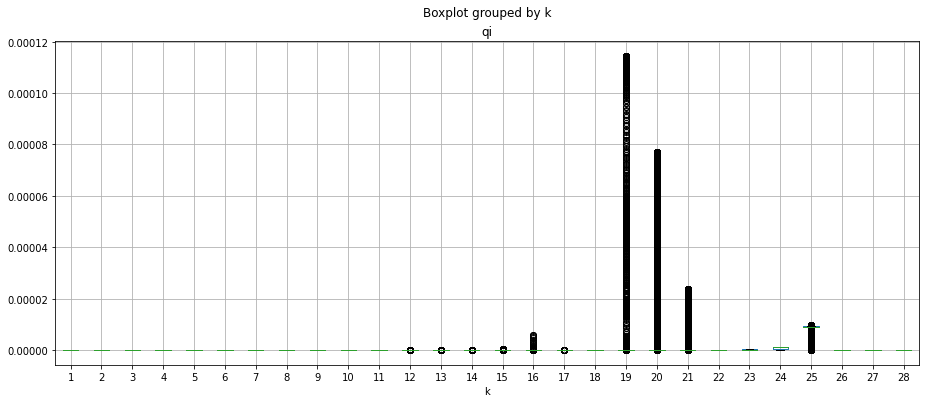

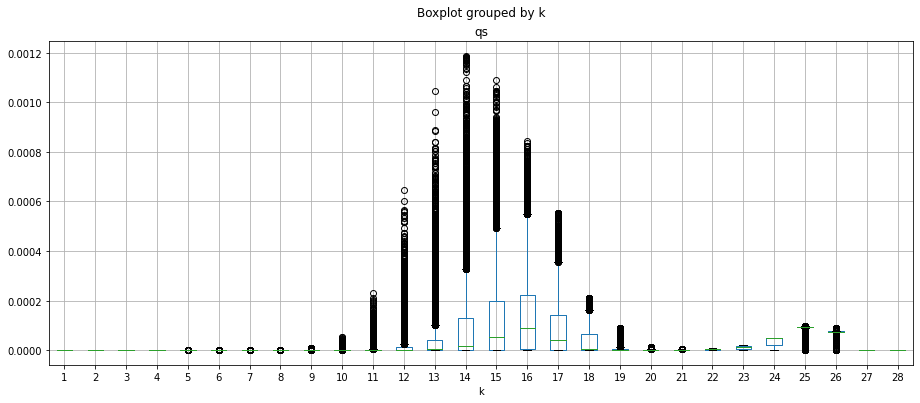

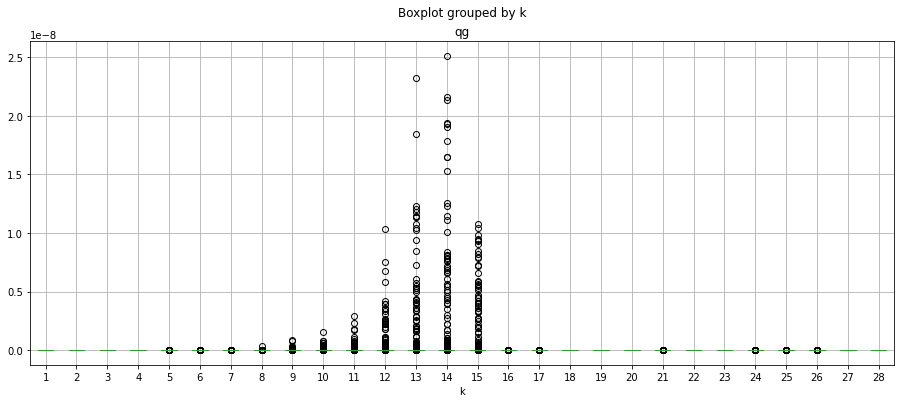

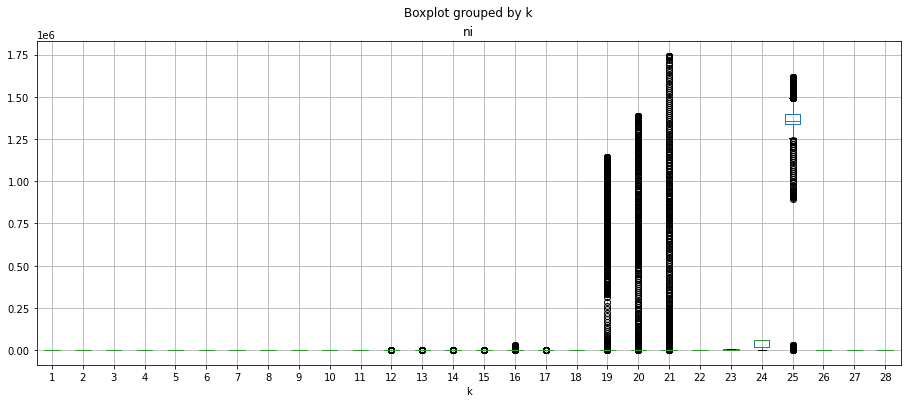

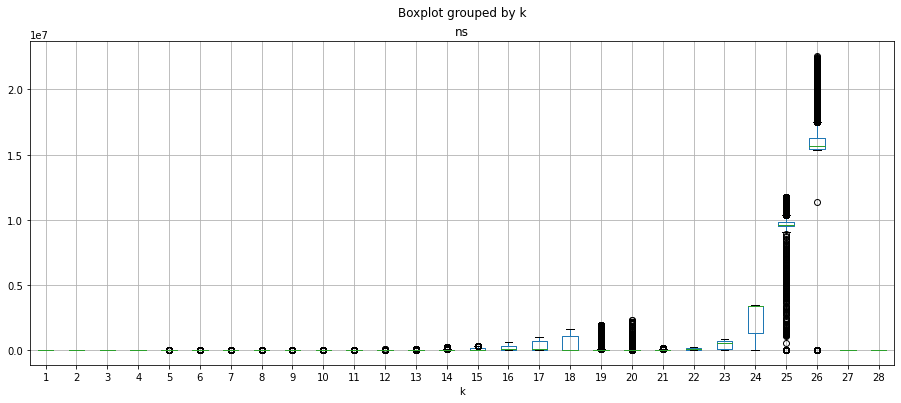

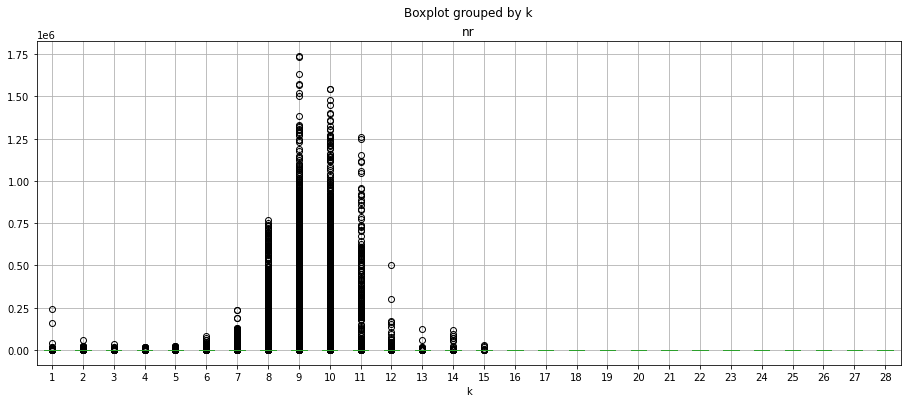

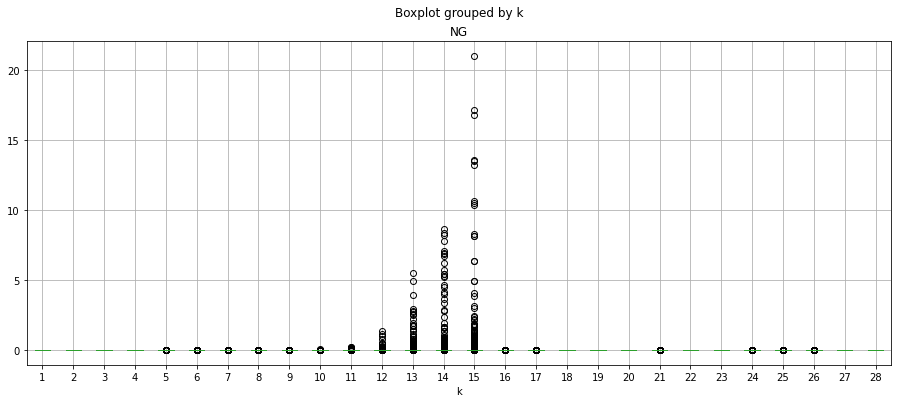

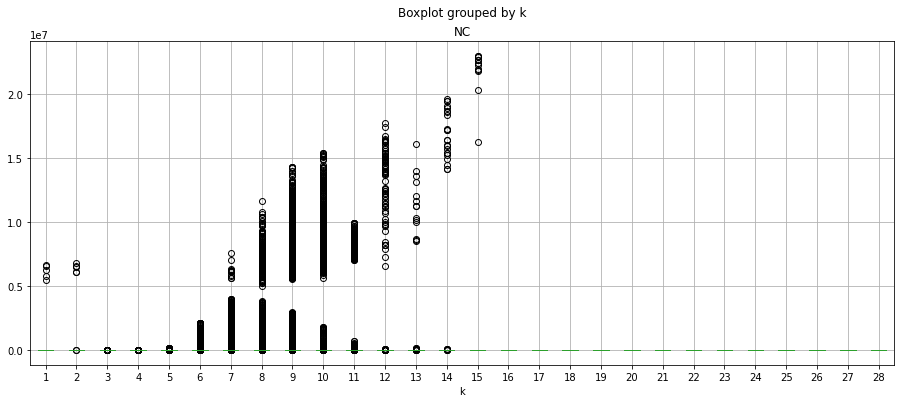

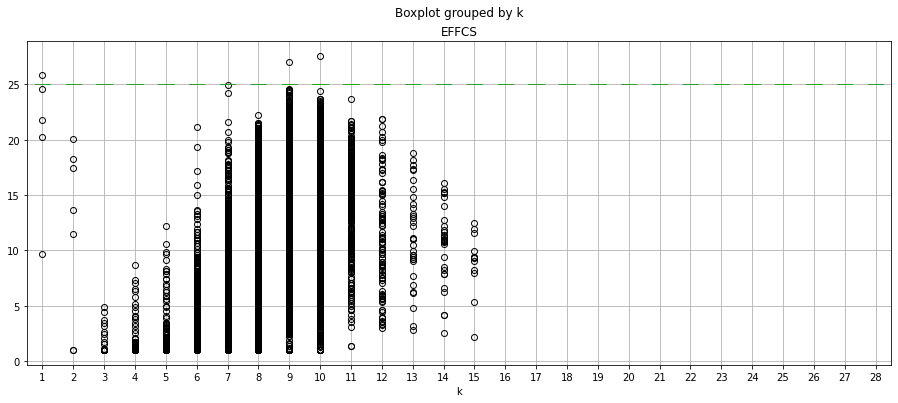

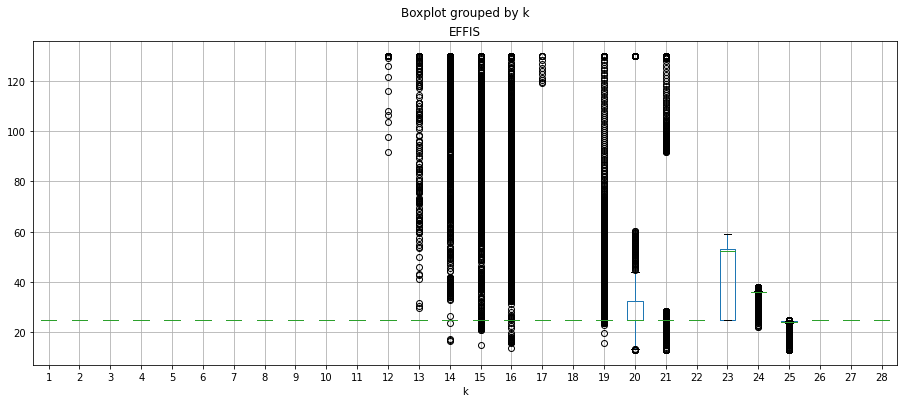

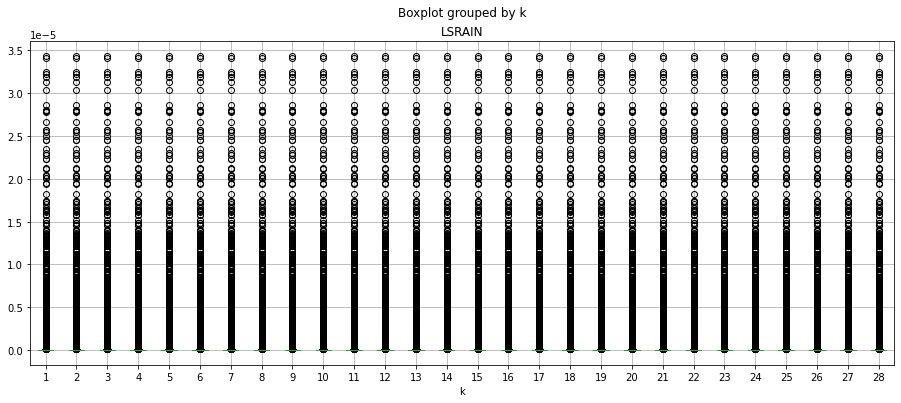

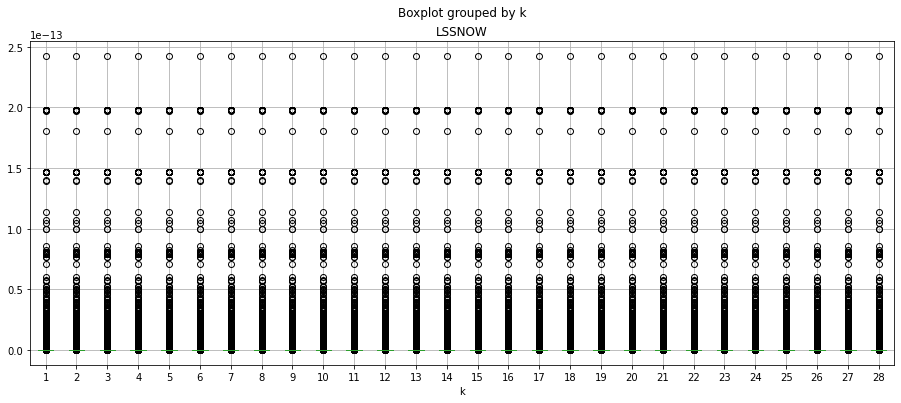

In [ ]:
# Boxplot of variables through levels

# for key in original_output_df.columns.tolist():
#     if key == "k": continue
#     # plt.subplot(6, 2, idx_plot)
#     original_output_df.boxplot(column=key, by="k", figsize=(15, 6))
# plt.show()

### Gráfico de perfil vertical das variáves de entrada em 3 timesteps

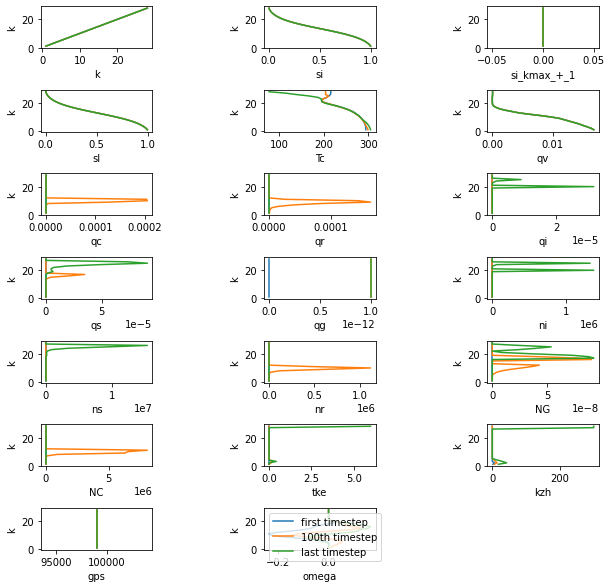

In [ ]:
# Plot the vertical levels of first, 100th and last timestep

# first_timestep_input_df = original_input_df.head(28)
# med_timestep_input_df = original_input_df.loc[2800:2800+27]
# last_timestep_input_df = original_input_df.tail(28)

# idx_plot = 1
# plt.figure(figsize=(10, 10))
# for key in last_timestep_input_df.columns.tolist():
#     plt.subplot(7, 3, idx_plot)
#     plt.ylabel("k")
#     plt.xlabel(key)
#     plt.plot(first_timestep_input_df[key], first_timestep_input_df[["k"]], label="first timestep")
#     plt.plot(med_timestep_input_df[key], med_timestep_input_df[["k"]], label="100th timestep")
#     plt.plot(last_timestep_input_df[key], last_timestep_input_df[["k"]], label="last timestep")
#     idx_plot += 1
# plt.legend(loc="upper left")
# plt.subplots_adjust(hspace=1, wspace=1)
# plt.show()


# first_timestep_output_df = original_output_df.head(28)
# med_timestep_output_df = original_output_df.loc[2801:2801+27]
# last_timestep_output_df = original_output_df.tail(28)

# idx_plot = 1
# for key in last_timestep_output_df.columns.tolist():
#     plt.subplot(4, 6, idx_plot)
#     plt.ylabel("k")
#     plt.xlabel(key)
#     plt.title("Output x Level")
#     plt.plot(first_timestep_output_df[key], first_timestep_output_df[["k"]], label="first timestep")
#     plt.plot(med_timestep_output_df[key], med_timestep_output_df[["k"]], label="100th timestep")
#     plt.plot(last_timestep_output_df[key], last_timestep_output_df[["k"]], label="last timestep")
#     plt.legend()
# plt.show()

## Pré-processando a entrada (exemplos) e saídas (metas)
- Selecionamos as primeiras variáveis de entrada e saída que serão usadas no treinamento e na validação;
- também podemos criar novas variáveis como um composto de variáveis

In [ ]:
def preprocess_features(input_df):
  """Prepares input features input_df

  Args:
    input data frame: A Pandas DataFrame expected to contain data from input data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
# All input variables
# "k", "si", "si_kmax_+_1", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "gps", "omega"    
  selected_features = input_df[
    [
    "k", "si", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "omega"    
    ]]
  processed_features = selected_features.copy()
  return processed_features


def preprocess_targets(output_df):
  """Prepares target features (i.e., labels) from output_df

  Args:
    output_df: A Pandas DataFrame expected to contain data from output data set.
  Returns:
    A DataFrame that contains the target features.
  """
# All output variables
# "k", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "EFFCS", "EFFIS", "LSRAIN", "LSSNOW"
  output_targets = output_df [
      [
      "k", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "EFFCS", "EFFIS", "LSRAIN", "LSSNOW"
      ]
  ]
  return output_targets


# execute the pre processing
all_examples = preprocess_features(original_input_df)
all_targets = preprocess_targets(original_output_df)


### Funções de normalização

In [ ]:
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

In [ ]:
# Different normalilzation functions

def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

### Normalização da base usando escala linear

Normalização das entradas para a escala -1, 1. para os primeiros testes

Como regra geral, o NN treina melhor quando os recursos de entrada estão aproximadamente na mesma escala.

Isso ajuda o NN a não ficar preso em etapas que são muito grandes em uma dimensão ou muito pequenas em outra.


In [ ]:
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  #
  # Your code here: normalize the inputs.
  #
    # Convert pandas data into a dict of np arrays.
#   processed_features = pd.DataFrame()
  processed_features = examples_dataframe.copy()
  for key,value in dict(examples_dataframe).items():
    if key != 'k':
      processed_features[key] = linear_scale(value)
  return processed_features



#### Boxplot das variáveis de entrada linearmente normalizadas

All normalized examples summary:


,k,si,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,omega
count,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000
mean,14.500000,-0.066812,-0.096078,0.405352,-0.307050,-0.993669,-0.991981,-0.983858,-0.950240,-0.999590,-0.929857,-0.907674,-0.994743,-0.999829,-0.989400,-0.909784,-0.809200,0.574896
std,8.077762,0.729800,0.726886,0.493977,0.753155,0.065028,0.051665,0.108332,0.141149,0.015516,0.319498,0.300784,0.058702,0.010571,0.085237,0.381426,0.525719,0.194582
min,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,7.750000,-0.798840,-0.820599,0.047516,-0.994740,-1.000000,-1.000000,-1.000000,-1.000000,-0.999920,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.999533,0.573916
50%,14.500000,-0.139702,-0.197953,0.570986,-0.731952,-1.000000,-1.000000,-1.000000,-0.999950,-0.999920,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.999533,0.624689
75%,21.250000,0.667721,0.630182,0.825954,0.435062,-1.000000,-1.000000,-1.000000,-0.976032,-0.999920,-1.000000,-0.996237,-1.000000,-1.000000,-1.000000,-1.000000,-0.999533,0.645794
max,28.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


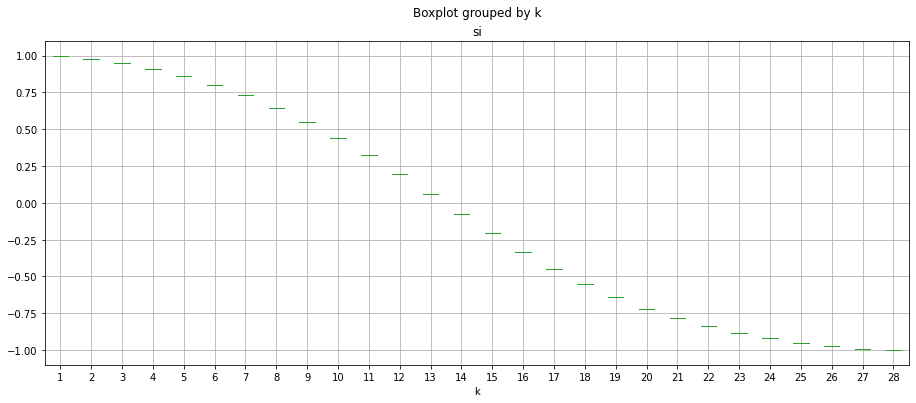

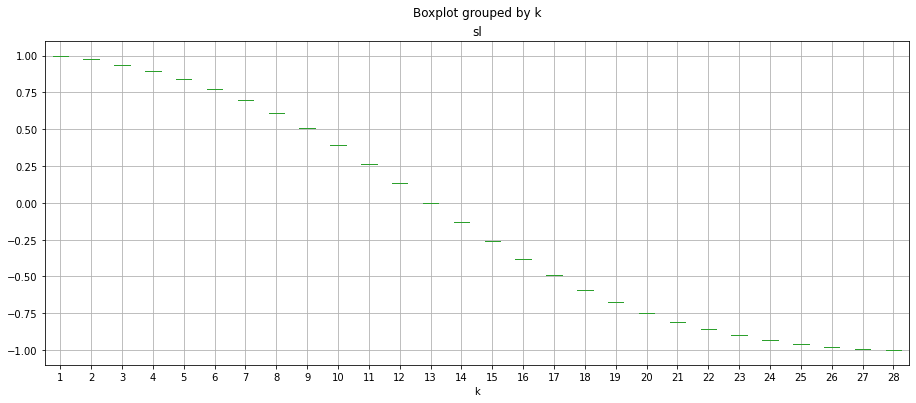

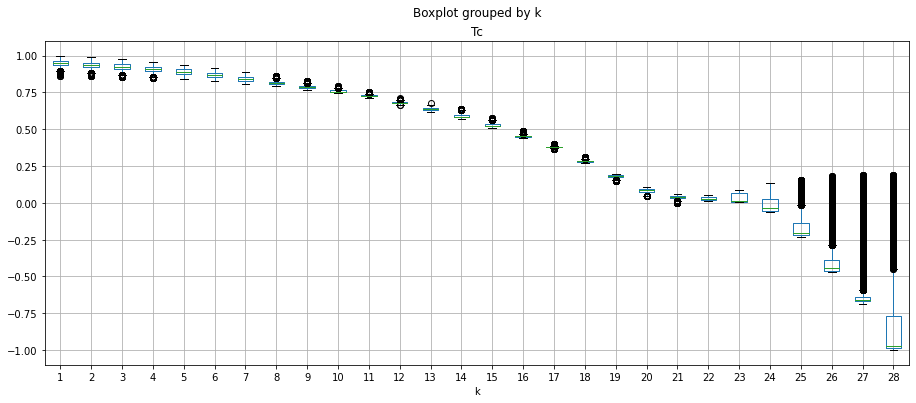

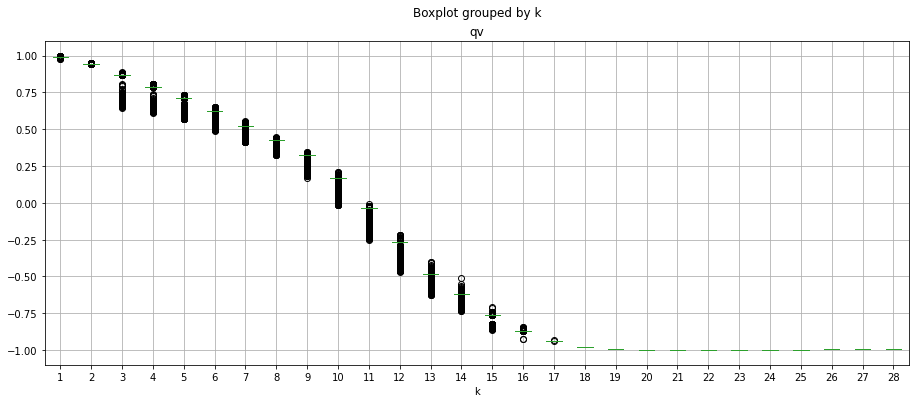

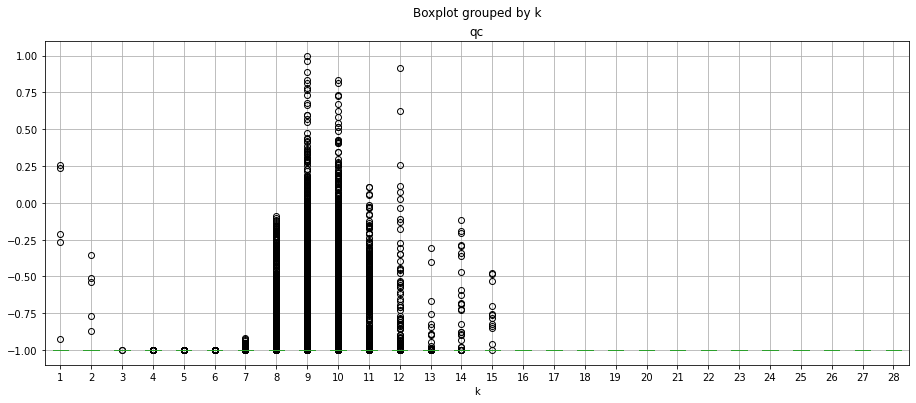

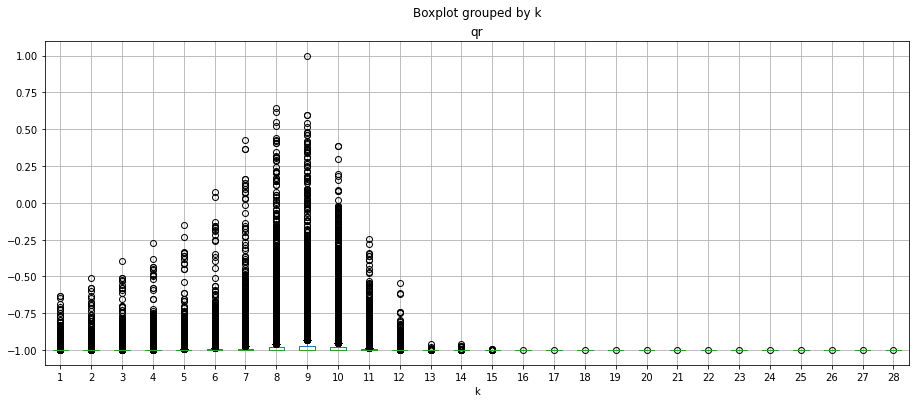

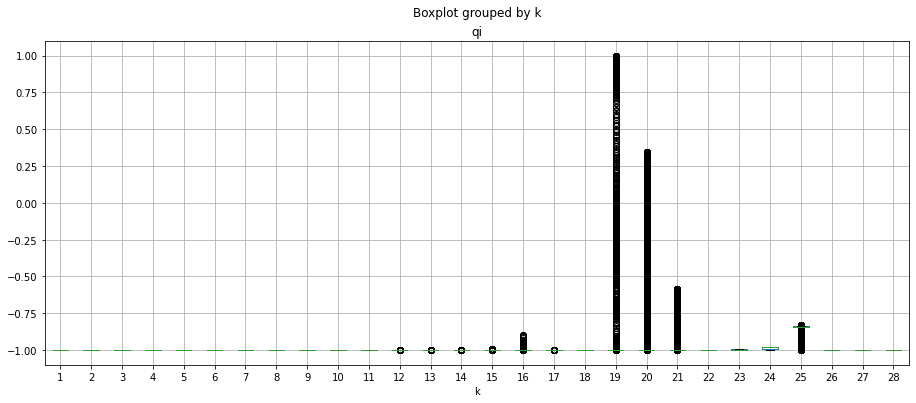

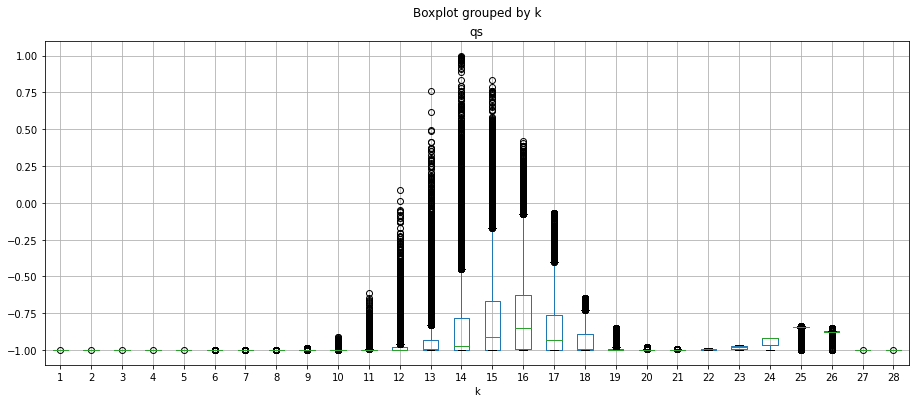

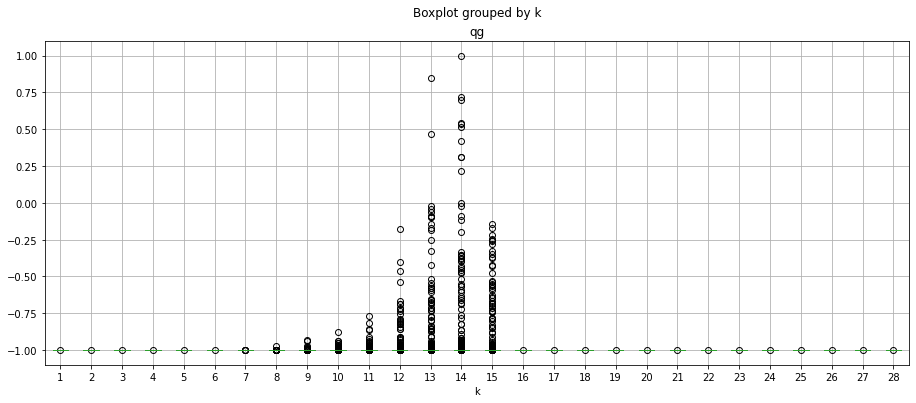

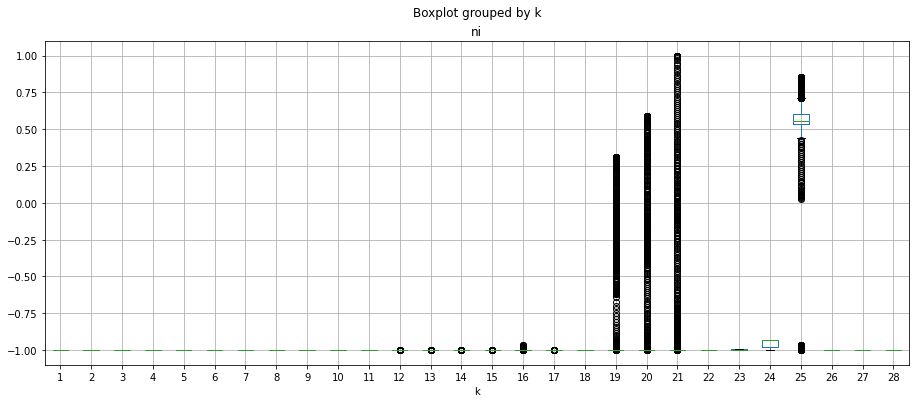

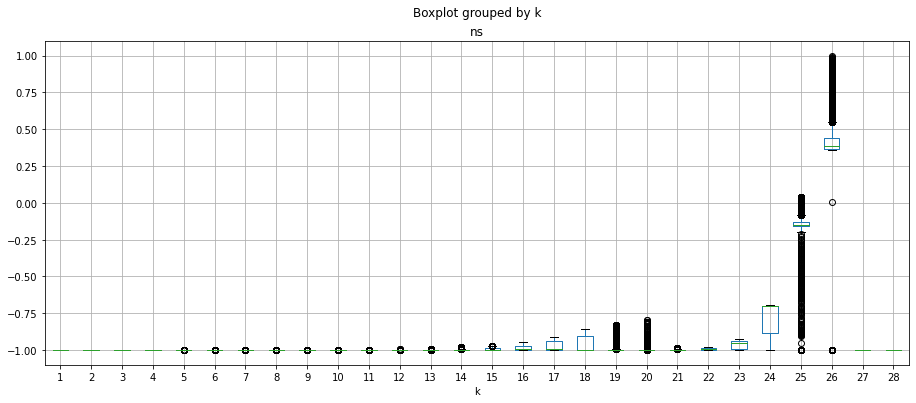

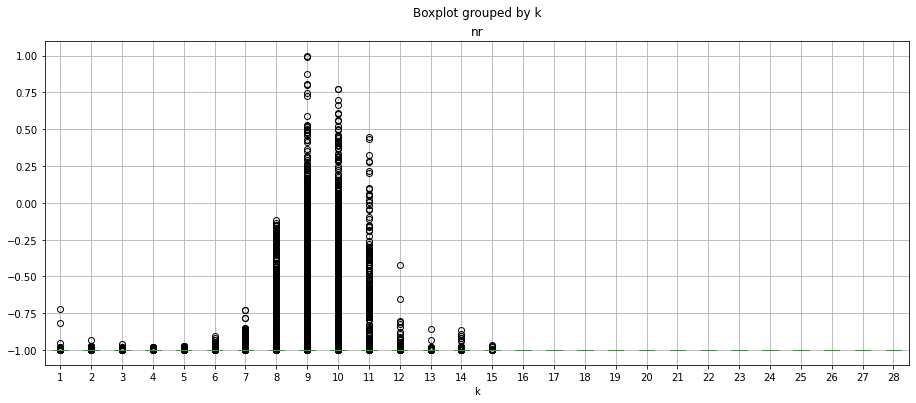

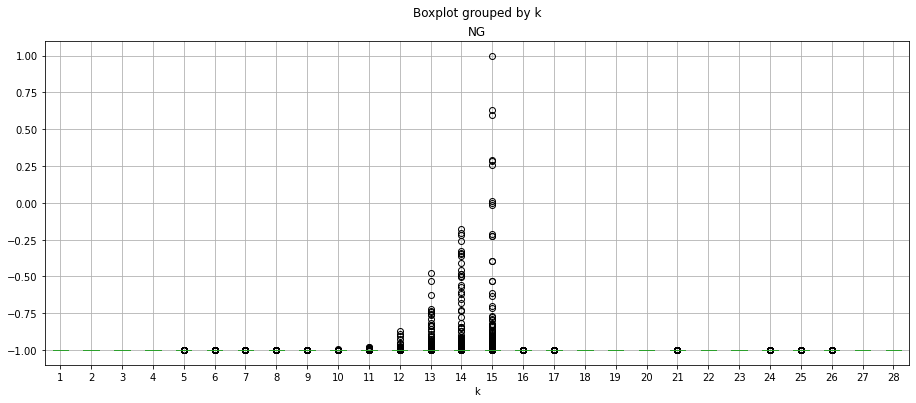

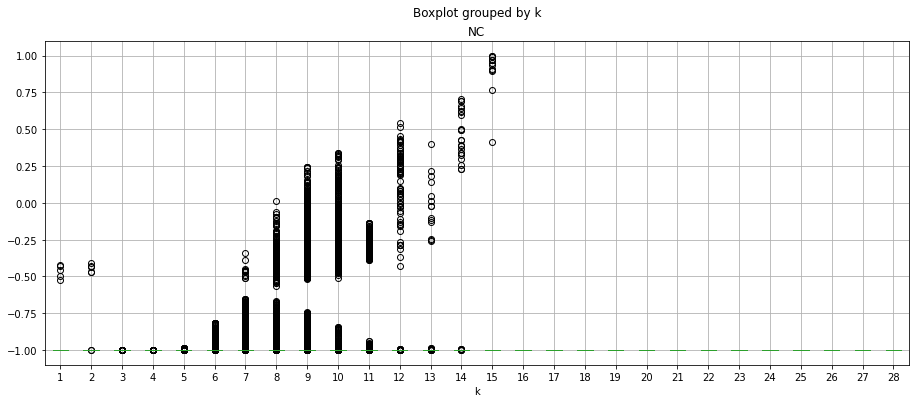

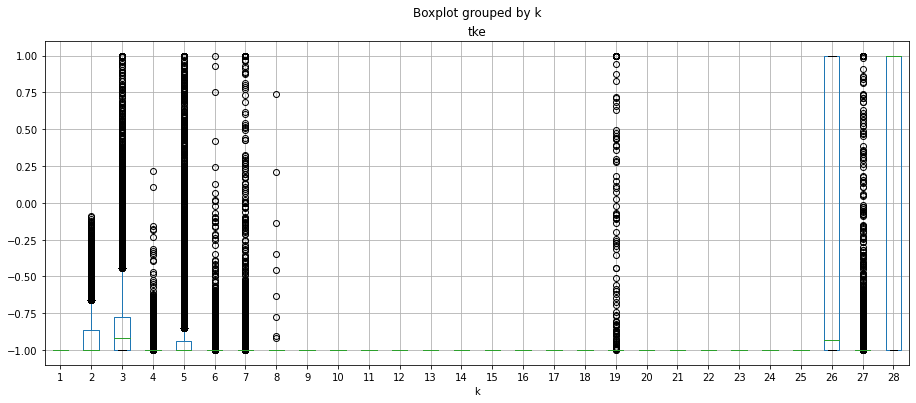

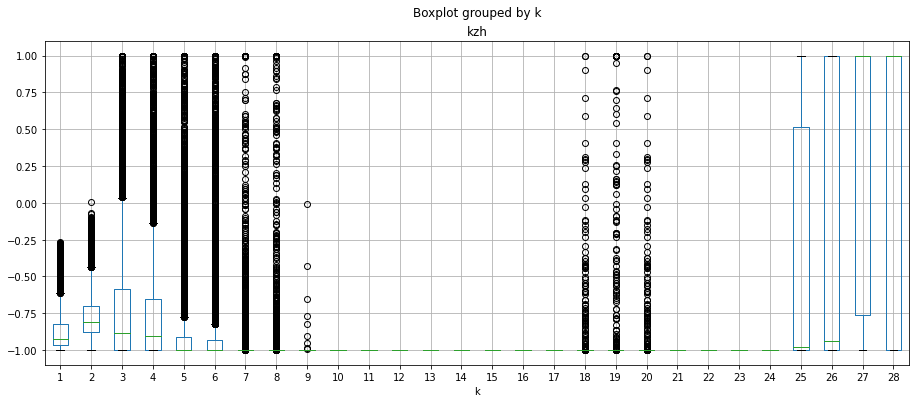

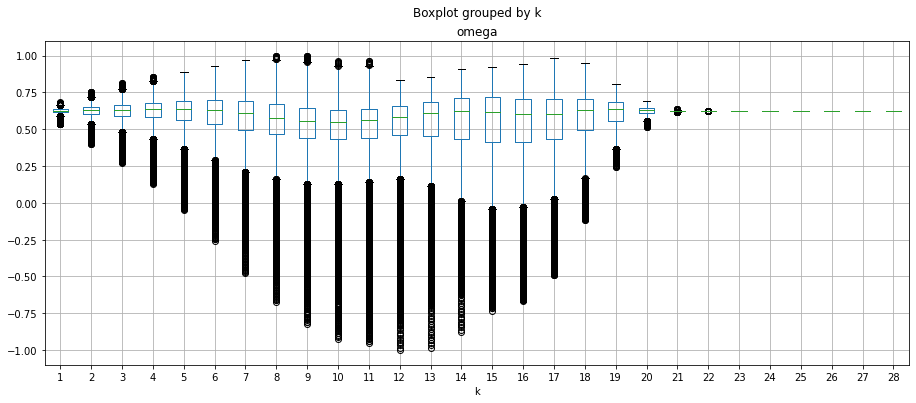

In [ ]:
#
# code below just to show
#

# normalized_all_examples = normalize_linear_scale(all_examples)

# print("All normalized examples summary:")
# display.display(normalized_all_examples.describe())

# # Boxplot of variables through levels
# for key in normalized_all_examples.columns.tolist():
#     if key == "k": continue
#     # plt.subplot(6, 2, idx_plot)
#     normalized_all_examples.boxplot(column=key, by="k", figsize=(15, 6))
# plt.show()

#### Boxplot das variáveis de saída linearmente normalizadas

All normalized targets summary:


,k,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
count,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000
mean,14.500000,0.405368,-0.311562,-0.993669,-0.991981,-0.983855,-0.950238,-0.999653,-0.929845,-0.907664,-0.994743,-0.999829,-0.989400,0.773415,-0.736271,-0.972897,-0.983997
std,8.077762,0.493932,0.748534,0.065028,0.051665,0.108337,0.141150,0.015518,0.319524,0.300797,0.058702,0.010571,0.085237,0.189538,0.249995,0.122947,0.112701
min,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,7.750000,0.047502,-0.996101,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.804039,-0.794872,-1.000000,-0.999988
50%,14.500000,0.572248,-0.719032,-1.000000,-1.000000,-1.000000,-0.999950,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.804039,-0.794872,-0.999997,-0.999837
75%,21.250000,0.825897,0.426582,-1.000000,-1.000000,-1.000000,-0.976027,-0.999980,-1.000000,-0.996237,-1.000000,-1.000000,-1.000000,0.804039,-0.794872,-0.997988,-0.998695
max,28.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


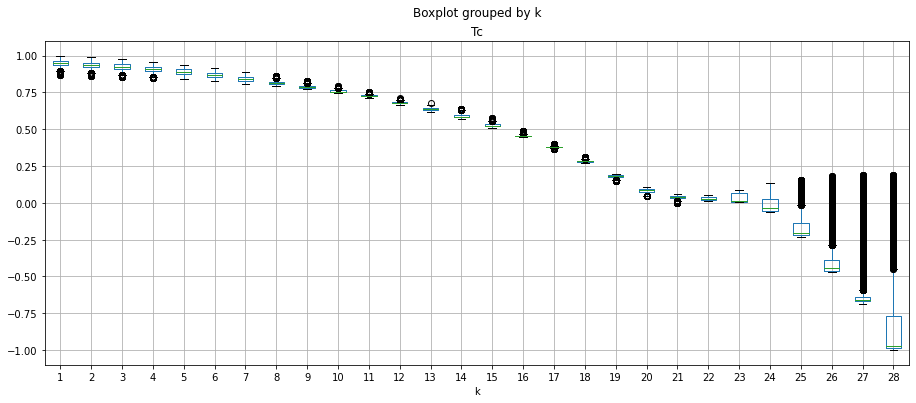

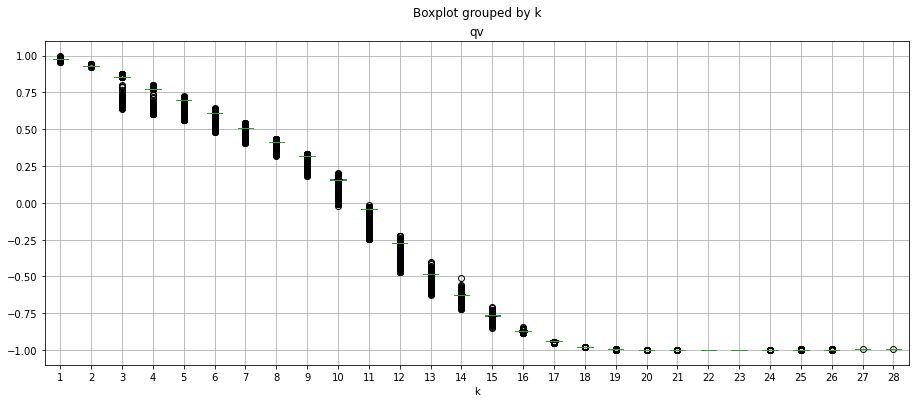

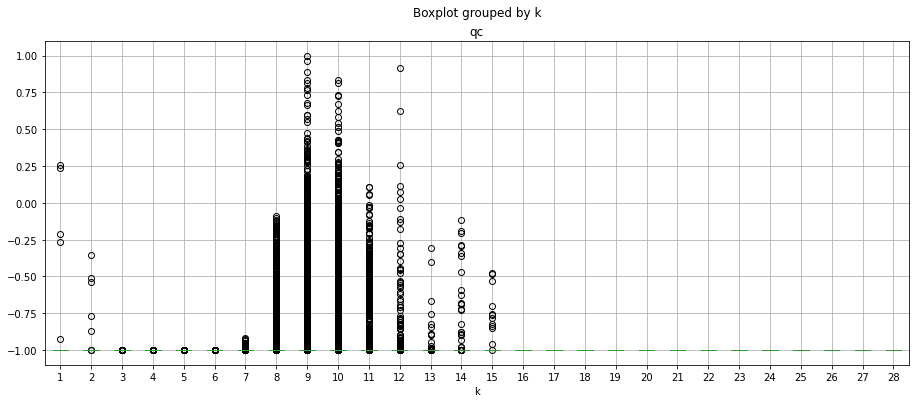

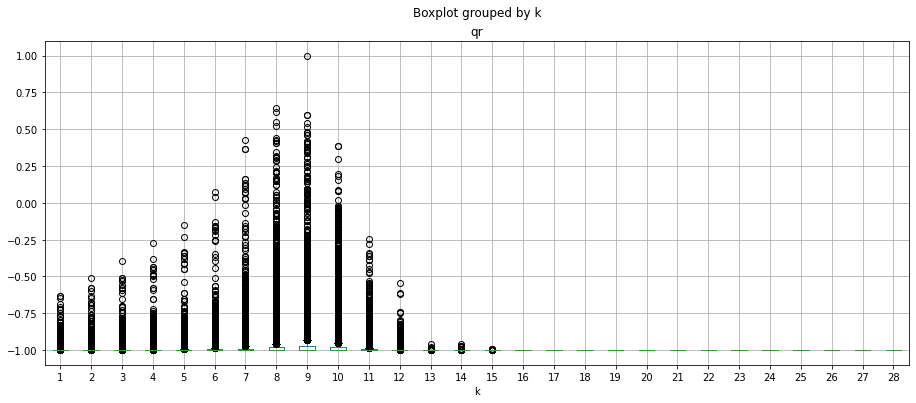

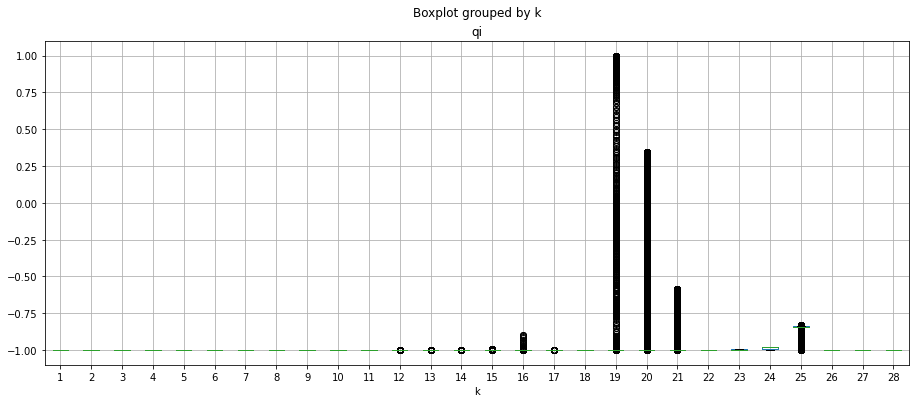

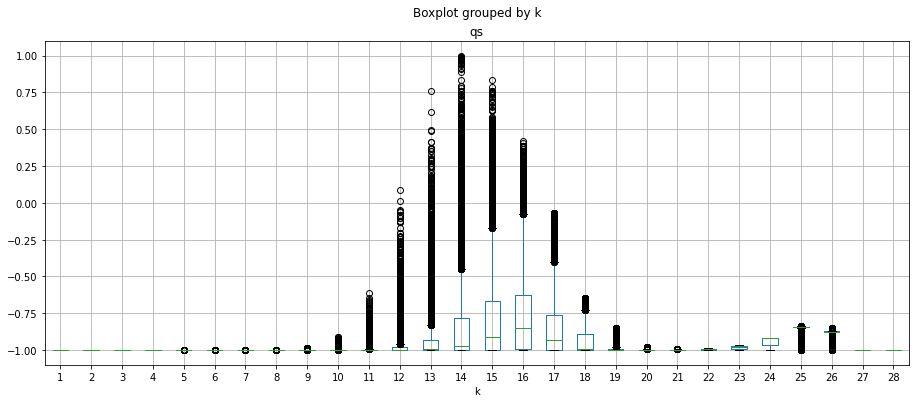

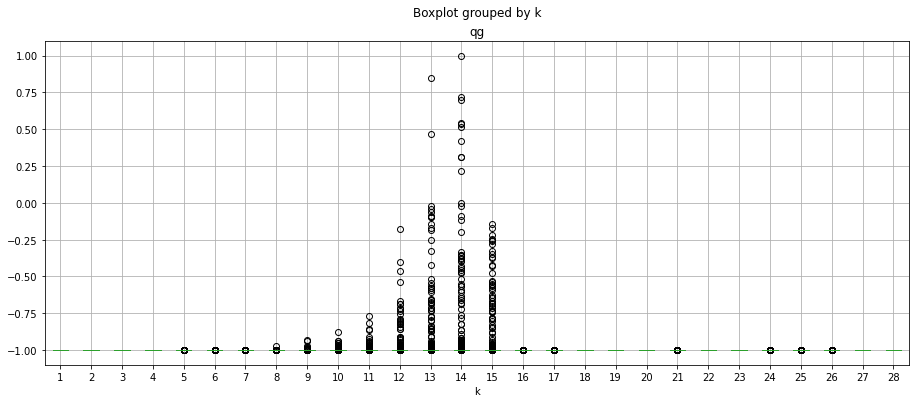

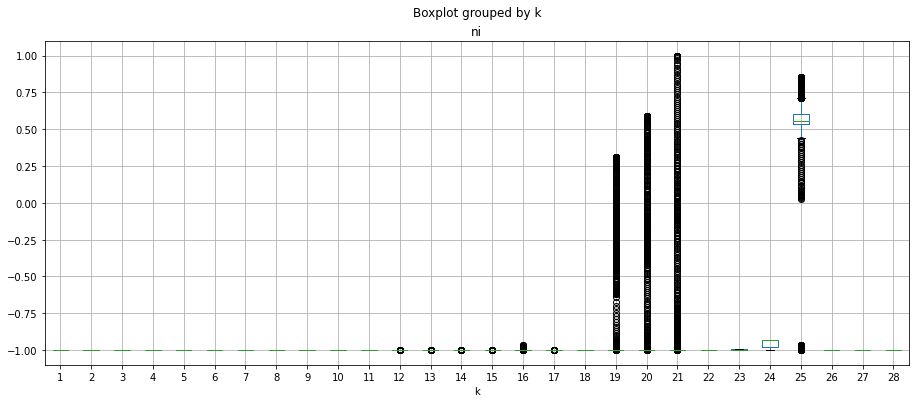

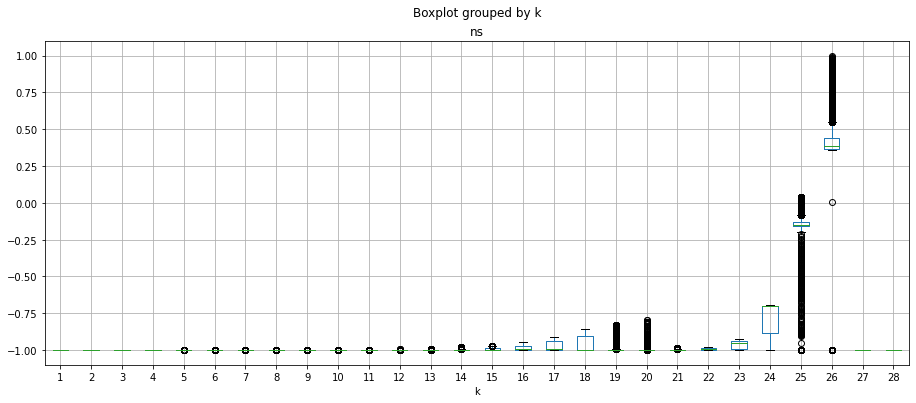

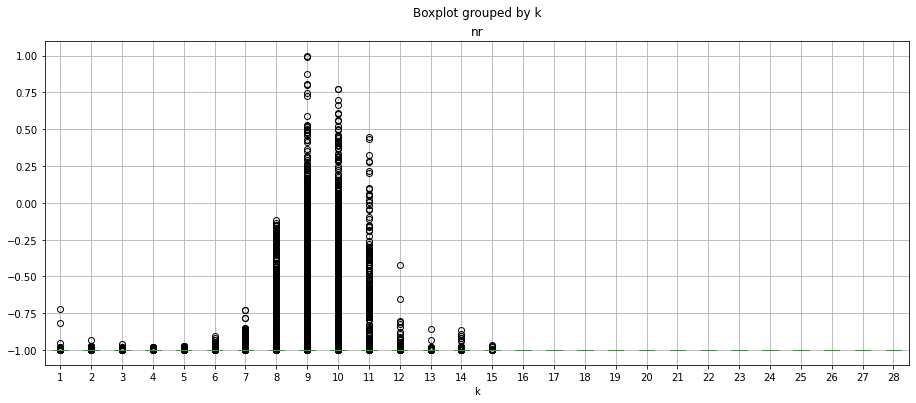

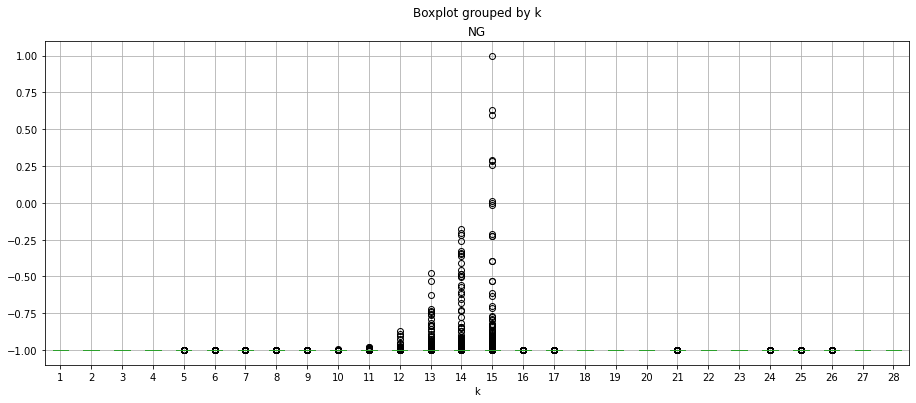

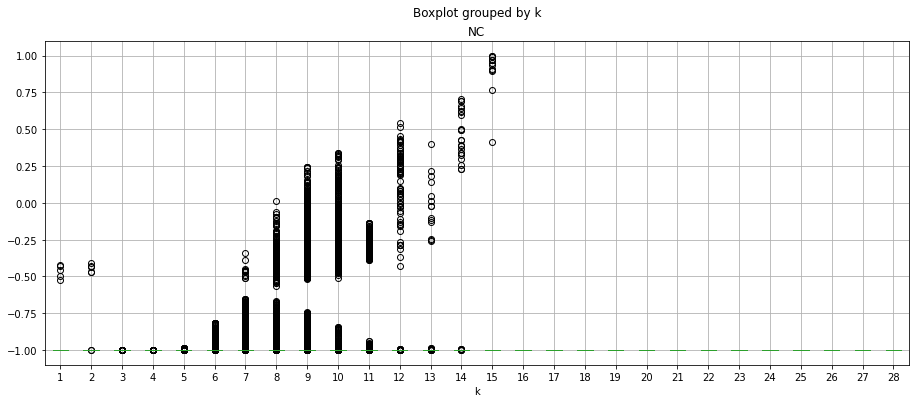

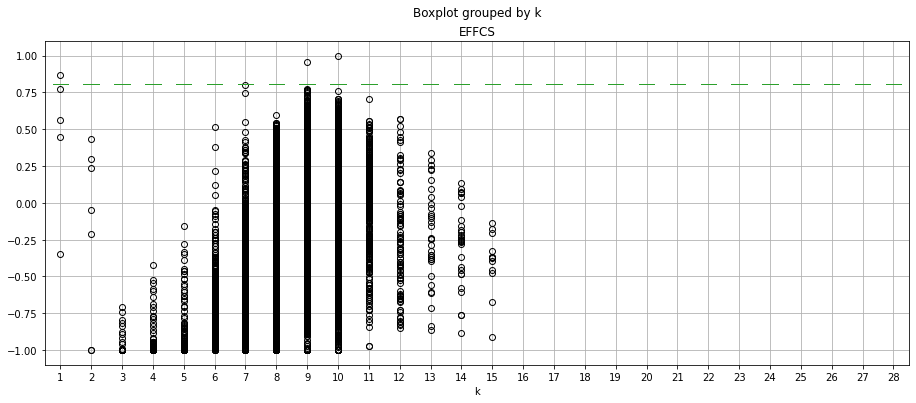

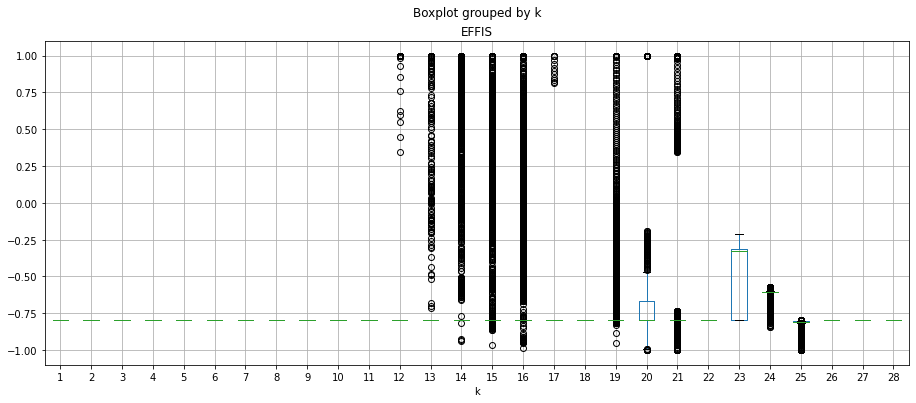

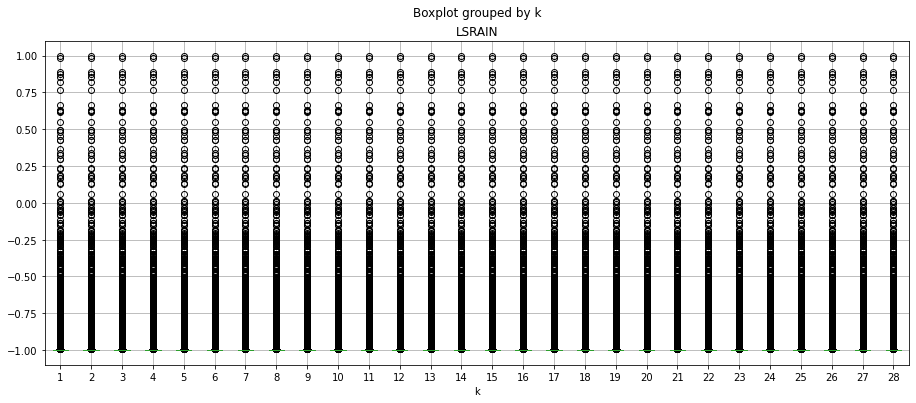

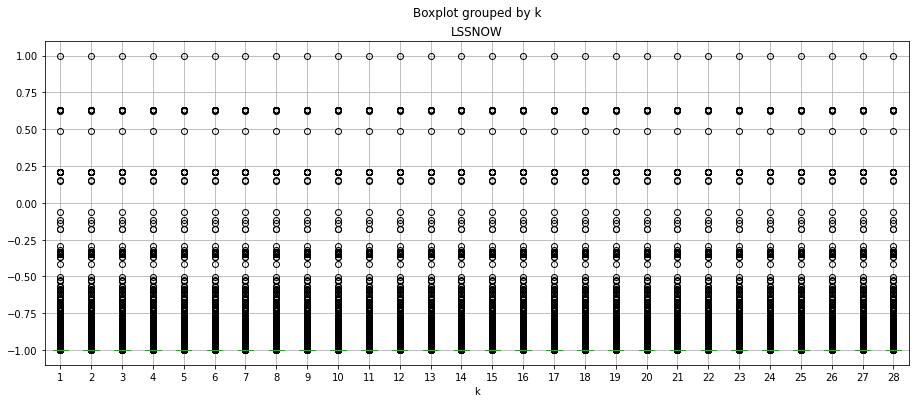

In [ ]:
#
# code below just to show
#

# normalized_all_targets = normalize_linear_scale(all_targets)

# print("All normalized targets summary:")
# display.display(normalized_all_targets.describe())

# # Boxplot of variables through levels
# for key in normalized_all_targets.columns.tolist():
#     if key == "k": continue
#     # plt.subplot(6, 2, idx_plot)
#     normalized_all_targets.boxplot(column=key, by="k", figsize=(15, 6))
# plt.show()

### Normalização da base usando diferentes escalas para cada variável

- Diferentes normalizações por variável, como linear, logarítimica e z-score


In [ ]:
def normalize_examples(examples_dataframe):
  # "k", "si", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "omega"
  processed_features = pd.DataFrame()

  if len(examples_dataframe["k"]) > 0:
    processed_features["k"] = examples_dataframe["k"]

  for m_var in [ "si", "sl", "Tc", "qv"]:
    processed_features[m_var] = linear_scale(examples_dataframe[m_var])

  for m_var in [ "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh"]:
    processed_features[m_var] = log_normalize(examples_dataframe[m_var])

  processed_features["omega"] = z_score_normalize(examples_dataframe["omega"])
  # processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))
    
  return processed_features


#### Boxplot das variáveis de entrada com diferentes normalizações

All normalized examples summary:


,k,si,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,omega
count,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000
mean,14.500000,-0.066812,-0.096078,0.405352,-0.307050,0.000002,0.000001,0.000001,0.000030,0.000000,1.225962,5.244949,0.761647,0.000743,0.403765,0.104675,1.029327,-0.000000
std,8.077762,0.729800,0.726886,0.493977,0.753155,0.000016,0.000009,0.000006,0.000084,0.000000,3.588118,5.950812,2.130680,0.031000,2.365943,0.391102,1.804910,1.000000
min,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029559,-8.093726
25%,7.750000,-0.798840,-0.820599,0.047516,-0.994740,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.095310,-0.005039
50%,14.500000,-0.139702,-0.197953,0.570986,-0.731952,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.303671,0.000000,0.000000,0.000000,0.000000,0.095310,0.255893
75%,21.250000,0.667721,0.630182,0.825954,0.435062,0.000000,0.000000,0.000000,0.000014,0.000000,0.000000,10.657978,0.000000,0.000000,0.000000,0.000000,0.095310,0.364360
max,28.000000,1.000000,1.000000,1.000000,1.000000,0.000493,0.000329,0.000115,0.001189,0.000000,14.371708,16.933672,14.369937,3.091543,16.950967,1.945910,5.707110,2.184698


All normalized targets summary:


,k,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
count,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000,265468.000000
mean,14.500000,0.405368,-0.311562,-0.993669,-0.991981,-0.983855,-0.950238,-0.999653,-0.929845,-0.907664,-0.994743,-0.999829,-0.989400,0.773415,-0.736271,-0.972897,-0.983997
std,8.077762,0.493932,0.748534,0.065028,0.051665,0.108337,0.141150,0.015518,0.319524,0.300797,0.058702,0.010571,0.085237,0.189538,0.249995,0.122947,0.112701
min,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,7.750000,0.047502,-0.996101,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.804039,-0.794872,-1.000000,-0.999988
50%,14.500000,0.572248,-0.719032,-1.000000,-1.000000,-1.000000,-0.999950,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.804039,-0.794872,-0.999997,-0.999837
75%,21.250000,0.825897,0.426582,-1.000000,-1.000000,-1.000000,-0.976027,-0.999980,-1.000000,-0.996237,-1.000000,-1.000000,-1.000000,0.804039,-0.794872,-0.997988,-0.998695
max,28.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


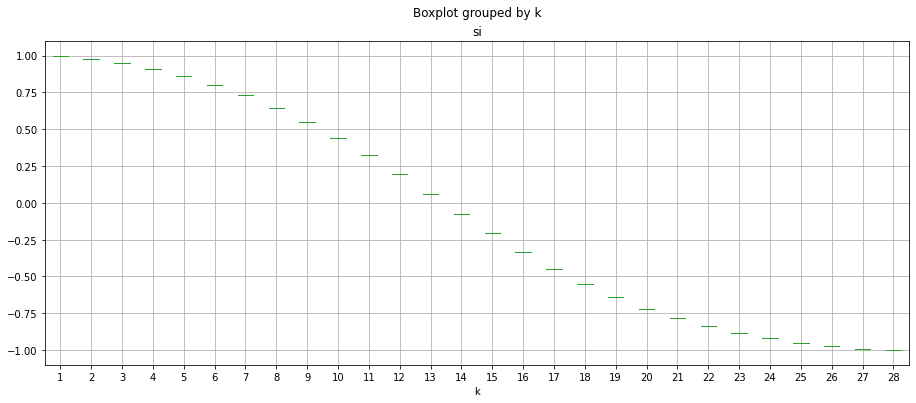

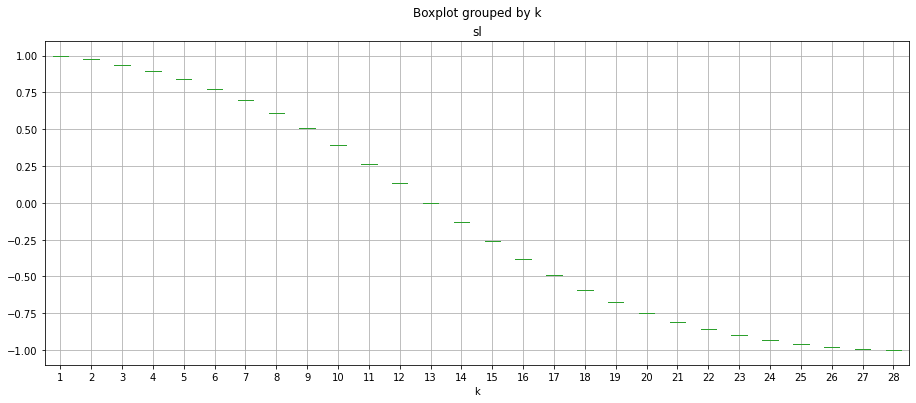

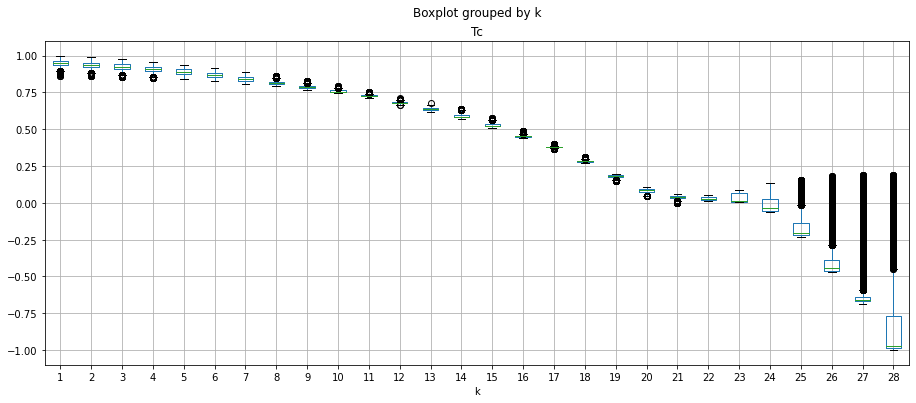

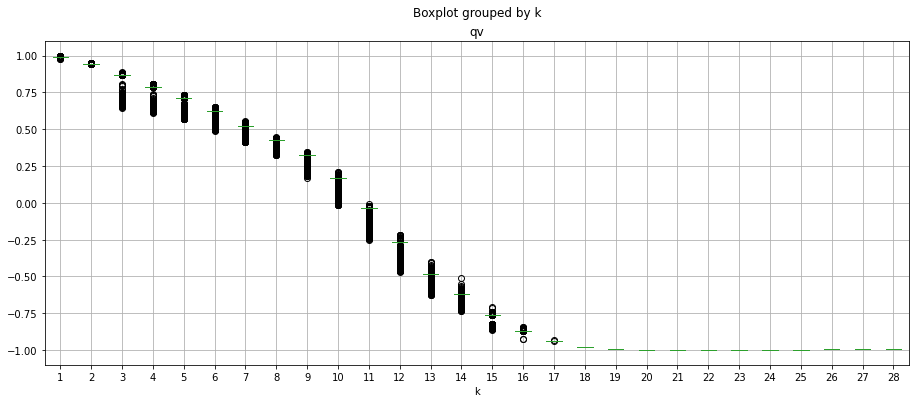

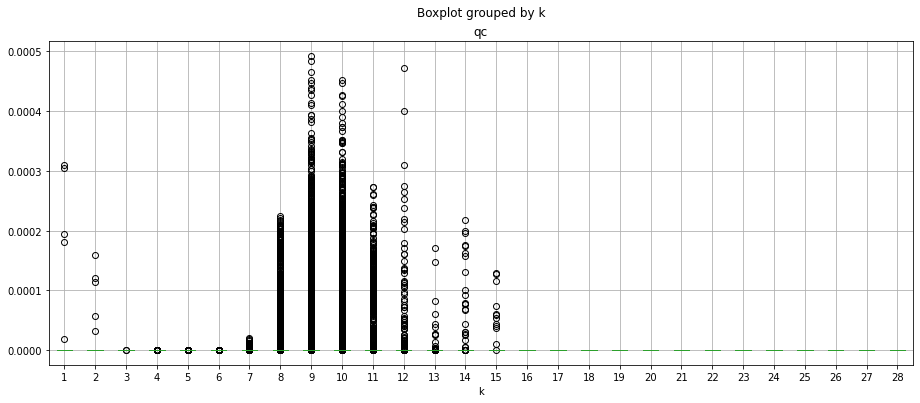

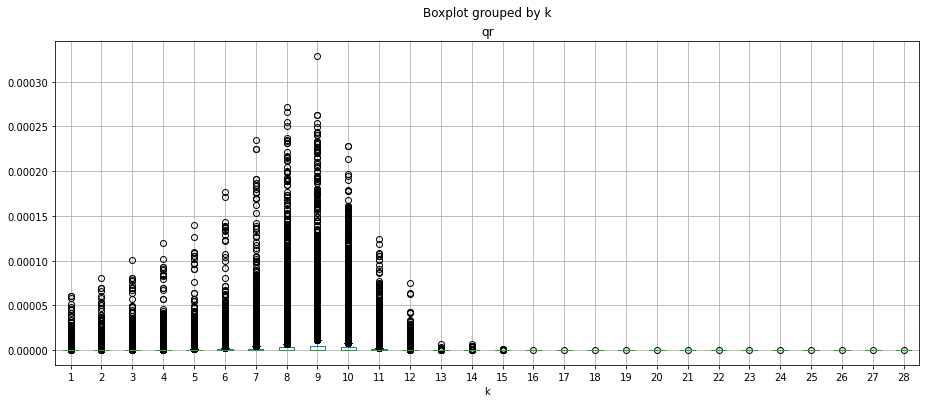

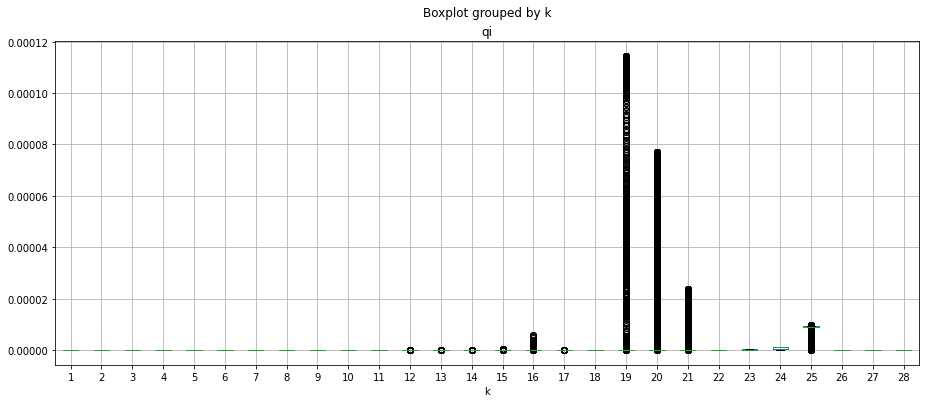

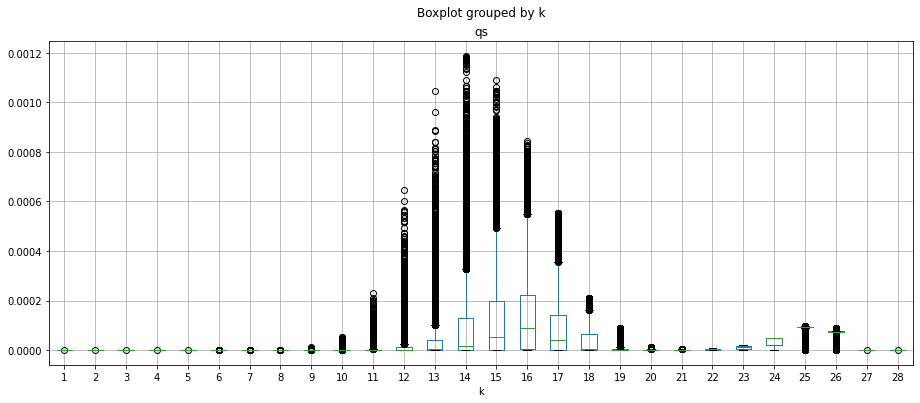

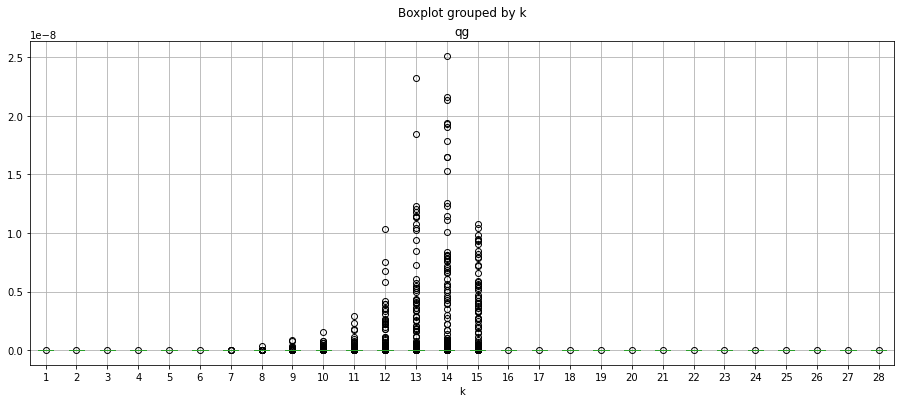

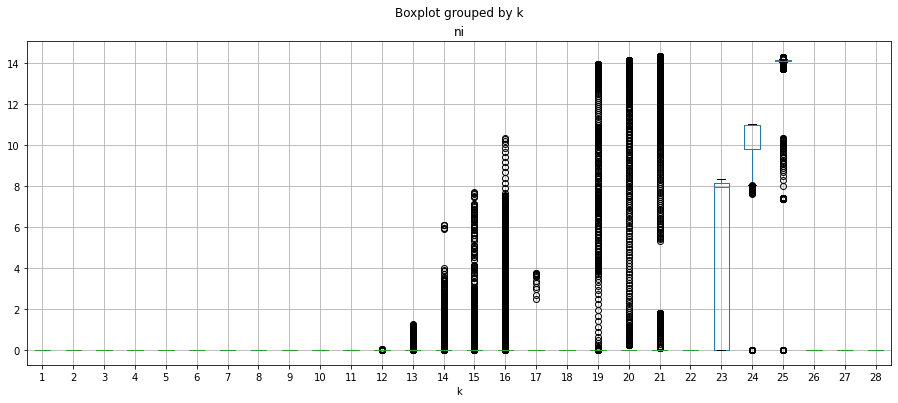

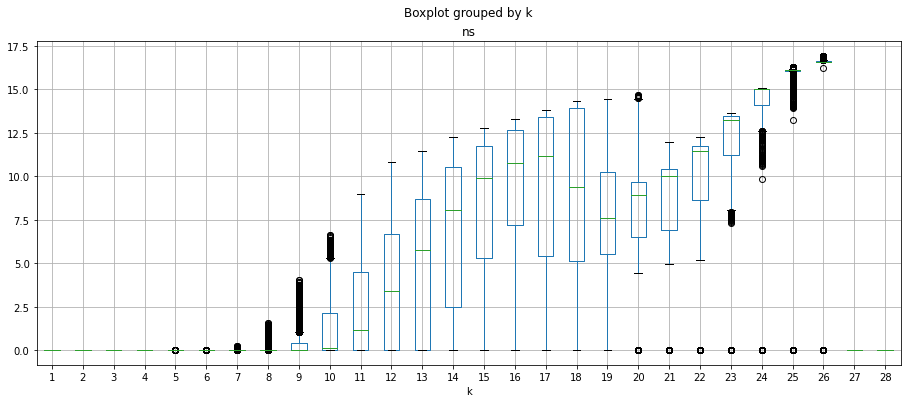

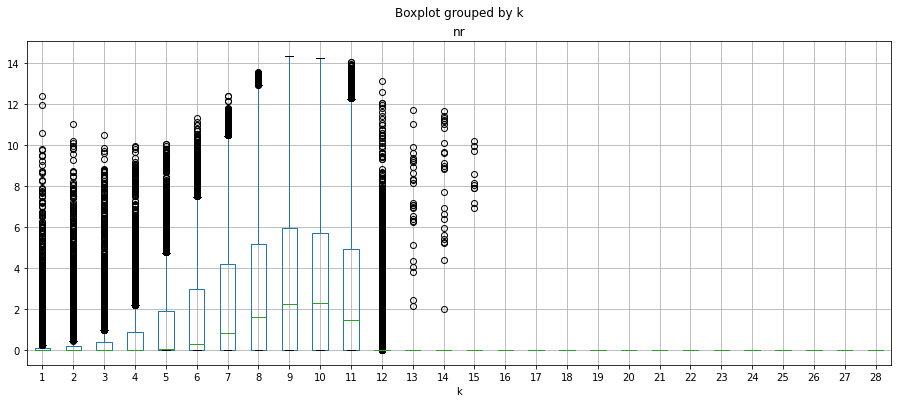

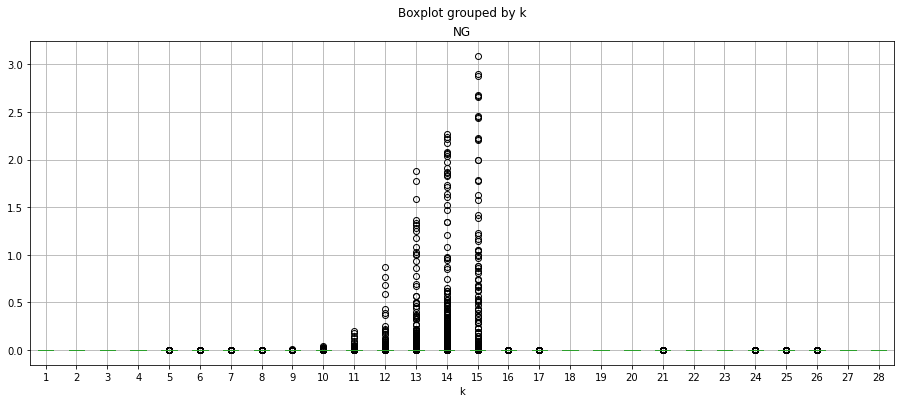

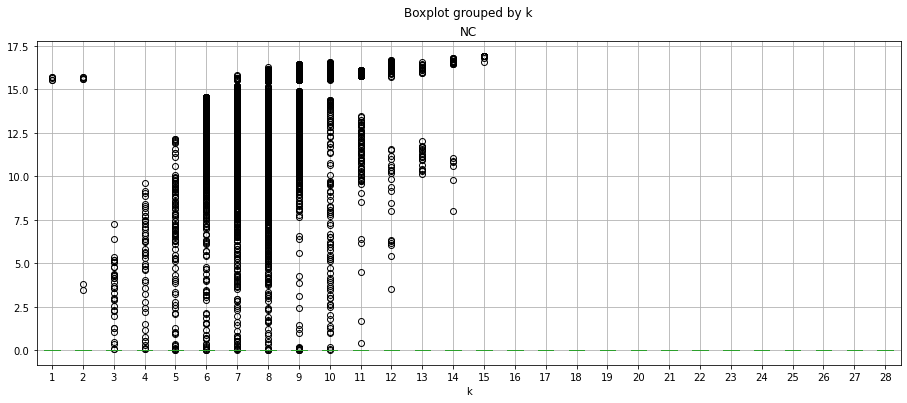

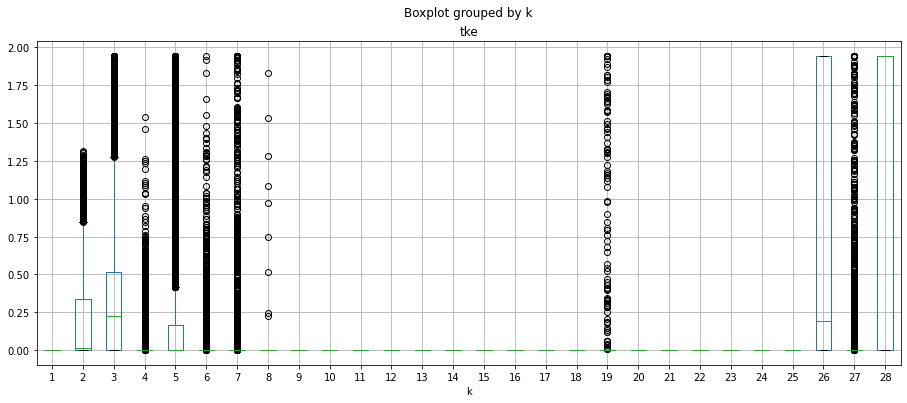

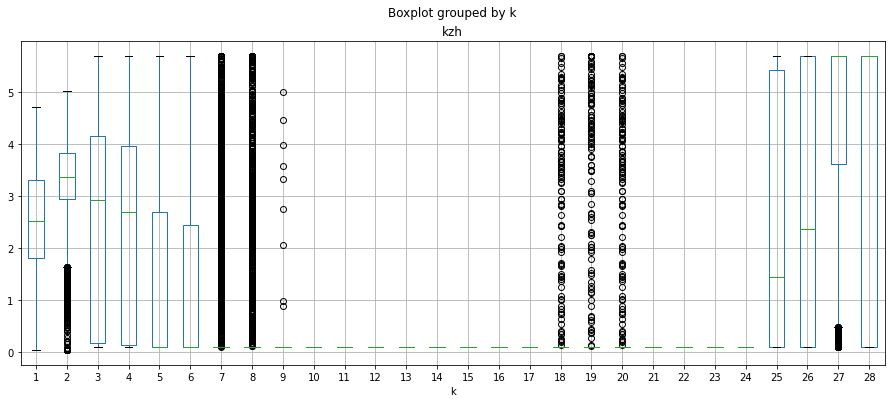

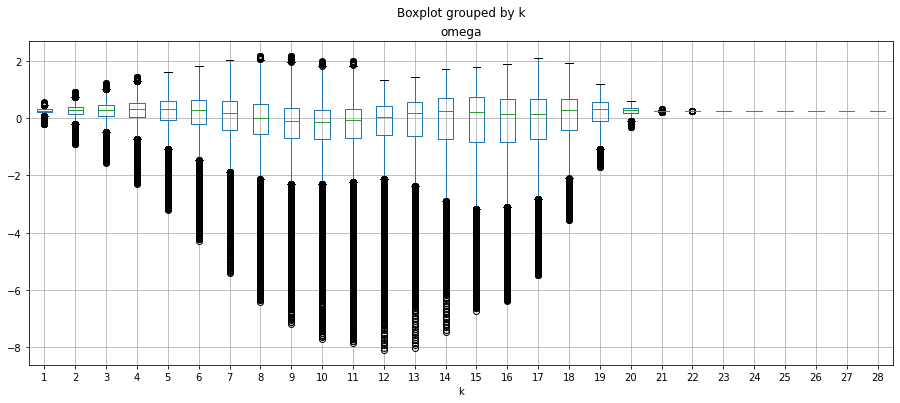

In [ ]:

normalized_all_examples = normalize_examples(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

print("All normalized examples summary:")
display.display(normalized_all_examples.describe())

print("All normalized targets summary:")
display.display(normalized_all_targets.describe())


# Boxplot of variables through levels
for key in normalized_all_examples.columns.tolist():
    if key == "k": continue
    # plt.subplot(6, 2, idx_plot)
    normalized_all_examples.boxplot(column=key, by="k", figsize=(15, 6))
plt.show()

## Amostras dos Conjuntos de treinamento e validação

Exibe  o resumo de entrada e saída de conjuntos de treinamento e validação, para verificar a homogeneidade desses conjuntos


In [ ]:
def get_90_percent_normalized_trainining_and_10_validation(normalized_all_examples, normalized_all_targets):
  # Choose the first 185808 (90%) (out of 265468) for training.
  train_size = 238896
  normalized_training_examples = normalized_all_examples.head(train_size)
  normalized_training_targets = normalized_all_targets.head(train_size)

  # Choose the last (10%) (out of 265468) for validation.
  normalized_validation_examples = normalized_all_examples.iloc[train_size:]
  normalized_validation_targets = normalized_all_targets.iloc[train_size:]
  return normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets


def get_70_percent_normalized_trainining_and_30_validation(normalized_all_examples, normalized_all_targets):
  # Choose the first 185808 (70%) (out of 265468) for training.
  train_size = 185808
  normalized_training_examples = normalized_all_examples.head(train_size)
  normalized_training_targets = normalized_all_targets.head(train_size)

  # Choose the last (30%) (out of 265468) for validation.
  normalized_validation_examples = normalized_all_examples.iloc[train_size:]
  normalized_validation_targets = normalized_all_targets.iloc[train_size:]
  return normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets


def get_10_percent_normalized_trainining_and_10_validation(normalized_all_examples, normalized_all_targets):
  # Choose the first 26544 (10%) (out of 265468) for training.
  train_size = 26544  
  ormalized_training_examples = normalized_all_examples.head(train_size)
  normalized_training_targets = normalized_all_targets.head(train_size)

  # Choose the last (30%) (out of 265468) for validation.
  normalized_validation_examples = normalized_all_examples.iloc[train_size+1:]
  normalized_validation_targets = normalized_all_targets.iloc[train_size+1:]
  return normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets


def get_df_col_k(df_orig, k_inicial, k_final):
  df_col_k = pd.DataFrame()
  for k in range(k_inicial, k_final + 1):
    df = df_orig.copy()
    df_k = df[df['k'] == k]
    for col in df.columns.tolist():
      if col == 'k':
        continue
      df_col_k['{}_k{}'.format(col, k)] = df_k[col].to_numpy()
  return df_col_k


def get_arr_2D_col_k(df_orig, colname, k_inicial, k_final):
  levels = k_final - k_inicial + 1
  rows_one_level = int(len(df_orig.index)/levels)
  arr_col_2d = np.zeros((rows_one_level, 28))

  for k in range(k_inicial, k_final + 1):
    df = df_orig.copy()
    df_k = df[df['k'] == k]
    arr_col_2d[:, k-1] = df_k[colname].to_numpy()
 
  return arr_col_2d

In [ ]:
# Choose variables to train and validate
# Eliminate variables are not varying
# Separate 70% for training and 30# for validation

training_examples_tmp, training_targets_tmp, validation_examples_tmp, validation_targets_tmp = get_70_percent_normalized_trainining_and_30_validation(all_examples, all_targets)

print("Training examples summary:")
display.display(training_examples_tmp.describe())

print("Validation examples summary:")
display.display(validation_examples_tmp.describe())

print("Training targets summary:")
display.display(training_targets_tmp.describe())

print("Validation targets summary:")
display.display(validation_targets_tmp.describe())


Training examples summary:


,k,si,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,omega
count,185808.000000,185808.000000,185808.000000,185808.000000,185808.000000,185808.000000,185808.000000,185808.000000,185808.000000,185808.000000,185808.000000,185808.000000,185808.000000,185808.000000,185808.000000,185808.000000,185808.000000,185808.000000
mean,14.500000,0.468551,0.450519,241.664063,0.005842,0.000002,0.000001,0.000001,0.000030,0.000000,56520.532606,1019896.181601,4980.377267,0.002567,140604.562359,0.223414,24.302614,-0.033589
std,8.077769,0.363561,0.361059,56.251172,0.006347,0.000017,0.000009,0.000006,0.000088,0.000000,268821.767677,3434205.913730,52970.948361,0.132731,1057925.946267,1.019283,71.302925,0.129691
min,1.000000,0.003669,0.001523,77.302427,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,-1.000858
25%,7.750000,0.103880,0.090635,199.791191,0.000047,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,-0.030174
50%,14.500000,0.432240,0.399916,260.253060,0.002218,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.994081,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000
75%,21.250000,0.834470,0.811268,289.907803,0.012114,0.000000,0.000000,0.000000,0.000012,0.000000,0.000000,28404.688206,0.000000,0.000000,0.000000,0.000000,0.100000,0.013628
max,28.000000,1.000000,0.994964,309.022749,0.016855,0.000493,0.000329,0.000115,0.001189,0.000000,1619376.775780,22604778.815400,1740941.655300,21.011023,22999124.957800,6.000000,300.000000,0.230311


Validation examples summary:


,k,si,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,omega
count,79660.000000,79660.000000,79660.000000,79660.000000,79660.000000,79660.000000,79660.000000,79660.000000,79660.000000,79660.000000,79660.000000,79660.000000,79660.000000,79660.000000,79660.000000,79660.000000,79660.000000,79660.000000
mean,14.500000,0.468551,0.450519,239.190187,0.005842,0.000001,0.000001,0.000001,0.000029,0.000000,71999.929046,1098559.929297,3633.191468,0.000004,78272.435998,0.380820,38.781011,-0.027915
std,8.077798,0.363563,0.361061,60.732858,0.006346,0.000015,0.000008,0.000006,0.000073,0.000000,299915.490225,3316770.303390,46423.685079,0.000576,767122.896944,1.386664,93.348558,0.111756
min,1.000000,0.003669,0.001523,76.927183,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,-1.040423
25%,7.750000,0.103880,0.090635,196.161752,0.000047,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,-0.037955
50%,14.500000,0.432240,0.399916,259.691733,0.002294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.619864,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000
75%,21.250000,0.834470,0.811268,290.321456,0.012072,0.000000,0.000000,0.000000,0.000017,0.000000,0.000000,125116.090663,0.000000,0.000000,0.000000,0.000000,0.215155,0.013230
max,28.000000,1.000000,0.994964,310.312954,0.016836,0.000439,0.000244,0.000068,0.000857,0.000000,1744027.026220,15533312.270600,1323742.164540,0.122004,17157937.683900,6.000000,300.000000,0.240343


Training targets summary:


,k,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
count,185808.000000,185808.000000,185808.000000,185808.000000,185808.000000,185808.000000,185808.000000,185808.000000,185808.000000,185808.000000,185808.000000,185808.000000,185808.000000,185808.000000,185808.000000,185808.000000,185808.000000
mean,14.500000,241.665942,0.005841,0.000002,0.000001,0.000001,0.000030,0.000000,56528.158471,1020053.328723,4980.377267,0.002567,140604.562359,24.520033,27.951298,0.000001,0.000000
std,8.077769,56.245764,0.006348,0.000017,0.000009,0.000006,0.000088,0.000000,268838.552726,3434426.673429,52970.948361,0.132731,1057925.946267,2.755052,13.353341,0.000002,0.000000
min,1.000000,77.302427,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,-0.000000,0.000000
25%,7.750000,199.787512,0.000036,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
50%,14.500000,260.397331,0.002343,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.003837,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
75%,21.250000,289.903621,0.012119,0.000000,0.000000,0.000000,0.000012,0.000000,0.000000,28408.801079,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
max,28.000000,309.022749,0.016964,0.000493,0.000329,0.000115,0.001189,0.000000,1619376.775780,22604778.815400,1740941.655300,21.011023,22999124.957800,27.606963,130.000000,0.000034,0.000000


Validation targets summary:


,k,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
count,79660.000000,79660.000000,79660.000000,79660.000000,79660.000000,79660.000000,79660.000000,79660.000000,79660.000000,79660.000000,79660.000000,79660.000000,79660.000000,79660.000000,79660.000000,79660.000000,79660.000000
mean,14.500000,239.192088,0.005842,0.000001,0.000001,0.000001,0.000029,0.000000,72017.173912,1098564.213038,3633.191468,0.000004,78272.435998,24.761826,29.540475,0.000000,0.000000
std,8.077798,60.727735,0.006347,0.000015,0.000008,0.000006,0.000073,0.000000,299950.843172,3316760.779970,46423.685079,0.000576,767122.896944,1.855511,17.178098,0.000002,0.000000
min,1.000000,76.927183,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,-0.000000,0.000000
25%,7.750000,196.157407,0.000034,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
50%,14.500000,259.770721,0.002395,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.610733,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
75%,21.250000,290.320342,0.012080,0.000000,0.000000,0.000000,0.000017,0.000000,0.000000,125131.009069,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
max,28.000000,310.312954,0.016836,0.000439,0.000244,0.000068,0.000857,0.000000,1744027.026220,15533312.270600,1323742.164540,0.122004,17157937.683900,25.000000,130.000000,0.000032,0.000000


In [ ]:
# Set using Variables per K
training_examples_tmp, training_targets_tmp, validation_examples_tmp, validation_targets_tmp = get_70_percent_normalized_trainining_and_30_validation(all_examples, all_targets)

k_inicial = 1
k_final = 28

training_examples_tmp = get_df_col_k(training_examples_tmp, k_inicial, k_final)
training_targets_tmp = get_df_col_k(training_targets_tmp, k_inicial, k_final)
validation_examples_tmp = get_df_col_k(validation_examples_tmp, k_inicial, k_final)
validation_targets_tmp = get_df_col_k(validation_targets_tmp, k_inicial, k_final)



display.display(training_examples_tmp.describe())
display.display(validation_examples_tmp.describe())
display.display(training_targets_tmp.describe())
display.display(validation_targets_tmp.describe())


,si_k1,sl_k1,Tc_k1,qv_k1,qc_k1,qr_k1,qi_k1,qs_k1,qg_k1,ni_k1,ns_k1,nr_k1,NG_k1,NC_k1,tke_k1,kzh_k1,omega_k1,si_k2,sl_k2,Tc_k2,qv_k2,qc_k2,qr_k2,qi_k2,qs_k2,qg_k2,ni_k2,ns_k2,nr_k2,NG_k2,NC_k2,tke_k2,kzh_k2,omega_k2,si_k3,sl_k3,Tc_k3,qv_k3,qc_k3,qr_k3,...,nr_k26,NG_k26,NC_k26,tke_k26,kzh_k26,omega_k26,si_k27,sl_k27,Tc_k27,qv_k27,qc_k27,qr_k27,qi_k27,qs_k27,qg_k27,ni_k27,ns_k27,nr_k27,NG_k27,NC_k27,tke_k27,kzh_k27,omega_k27,si_k28,sl_k28,Tc_k28,qv_k28,qc_k28,qr_k28,qi_k28,qs_k28,qg_k28,ni_k28,ns_k28,nr_k28,NG_k28,NC_k28,tke_k28,kzh_k28,omega_k28
count,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,...,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000
mean,1.000000,0.994964,303.954871,0.016781,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,85.313340,0.000000,4634.793530,0.000001,18.224161,-0.001482,0.989934,0.981964,302.874476,0.016365,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,39.868674,0.000000,4810.531657,0.334050,32.687029,-0.002320,0.974009,0.964137,301.409955,0.015740,0.000000,0.000001,...,0.000000,0.000000,0.000000,1.966394,99.886614,0.000000,0.007338,0.005429,127.275658,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.096329,165.665581,0.000000,0.003669,0.001523,105.825343,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.673599,135.563975,0.000000
std,0.000000,0.000000,2.089241,0.000006,0.000006,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,3591.105451,0.000000,169255.527336,0.000000,19.021205,0.012536,0.000000,0.000000,2.099140,0.000007,0.000003,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,955.855961,0.000000,175361.381207,0.568124,23.083747,0.029899,0.000000,0.000000,2.138286,0.000110,0.000000,0.000004,...,0.000000,0.000000,0.000000,2.559231,126.794945,0.000000,0.000000,0.000000,22.310584,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.579587,139.610646,0.000000,0.000000,0.000000,35.949288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.982416,148.002467,0.000000
min,1.000000,0.994964,294.178437,0.016646,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032500,-0.059305,0.989934,0.981964,293.941749,0.016364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,-0.144502,0.974009,0.964137,293.560303,0.013922,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.007338,0.005429,114.207522,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.003669,0.001523,77.302427,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000
25%,1.000000,0.994964,302.666795,0.016781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.023927,-0.005238,0.989934,0.981964,301.567005,0.016364,0.000000,0.000000,0.000000,0.00000

,si_k1,sl_k1,Tc_k1,qv_k1,qc_k1,qr_k1,qi_k1,qs_k1,qg_k1,ni_k1,ns_k1,nr_k1,NG_k1,NC_k1,tke_k1,kzh_k1,omega_k1,si_k2,sl_k2,Tc_k2,qv_k2,qc_k2,qr_k2,qi_k2,qs_k2,qg_k2,ni_k2,ns_k2,nr_k2,NG_k2,NC_k2,tke_k2,kzh_k2,omega_k2,si_k3,sl_k3,Tc_k3,qv_k3,qc_k3,qr_k3,...,nr_k26,NG_k26,NC_k26,tke_k26,kzh_k26,omega_k26,si_k27,sl_k27,Tc_k27,qv_k27,qc_k27,qr_k27,qi_k27,qs_k27,qg_k27,ni_k27,ns_k27,nr_k27,NG_k27,NC_k27,tke_k27,kzh_k27,omega_k27,si_k28,sl_k28,Tc_k28,qv_k28,qc_k28,qr_k28,qi_k28,qs_k28,qg_k28,ni_k28,ns_k28,nr_k28,NG_k28,NC_k28,tke_k28,kzh_k28,omega_k28
count,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,...,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000
mean,1.000000,0.994964,304.459287,0.016781,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,10.745964,0.000000,0.000000,0.000001,21.579321,-0.001323,0.989934,0.981964,303.464550,0.016365,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,14.380843,0.000000,0.000000,0.337241,38.386657,-0.002494,0.974009,0.964137,302.062306,0.015734,0.000000,0.000001,...,0.000000,0.000000,0.000000,2.809550,127.754189,0.000000,0.007338,0.005429,115.191737,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,300.000000,0.000000,0.003669,0.001523,78.763329,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,300.000000,0.000000
std,0.000000,0.000000,2.499595,0.000005,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,357.822952,0.000000,0.000000,0.000000,23.660057,0.012671,0.000000,0.000000,2.580691,0.000006,0.000000,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,485.762748,0.000000,0.000000,0.557491,28.289619,0.028686,0.000000,0.000000,2.637314,0.000149,0.000000,0.000003,...,0.000000,0.000000,0.000000,2.907518,142.410115,0.000000,0.000000,0.000000,0.865406,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.143988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,1.000000,0.994964,299.938781,0.016711,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032500,-0.055549,0.989934,0.981964,299.099233,0.016364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,-0.120728,0.974009,0.964137,297.821594,0.013876,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.007338,0.005429,113.699317,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,300.000000,0.000000,0.003669,0.001523,76.927183,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,300.000000,0.000000
25%,1.000000,0.994964,302.167009,0.016781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.296357,-0.006696,0.989934,0.981964,301.101952,0.016364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

,Tc_k1,qv_k1,qc_k1,qr_k1,qi_k1,qs_k1,qg_k1,ni_k1,ns_k1,nr_k1,NG_k1,NC_k1,EFFCS_k1,EFFIS_k1,LSRAIN_k1,LSSNOW_k1,Tc_k2,qv_k2,qc_k2,qr_k2,qi_k2,qs_k2,qg_k2,ni_k2,ns_k2,nr_k2,NG_k2,NC_k2,EFFCS_k2,EFFIS_k2,LSRAIN_k2,LSSNOW_k2,Tc_k3,qv_k3,qc_k3,qr_k3,qi_k3,qs_k3,qg_k3,ni_k3,...,ns_k26,nr_k26,NG_k26,NC_k26,EFFCS_k26,EFFIS_k26,LSRAIN_k26,LSSNOW_k26,Tc_k27,qv_k27,qc_k27,qr_k27,qi_k27,qs_k27,qg_k27,ni_k27,ns_k27,nr_k27,NG_k27,NC_k27,EFFCS_k27,EFFIS_k27,LSRAIN_k27,LSSNOW_k27,Tc_k28,qv_k28,qc_k28,qr_k28,qi_k28,qs_k28,qg_k28,ni_k28,ns_k28,nr_k28,NG_k28,NC_k28,EFFCS_k28,EFFIS_k28,LSRAIN_k28,LSSNOW_k28
count,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,...,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000
mean,303.953748,0.016781,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,85.313340,0.000000,4634.793530,24.996556,25.000000,0.000001,0.000000,302.873131,0.016366,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,39.868674,0.000000,4810.531657,24.986122,25.000000,0.000001,0.000000,301.408421,0.015741,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,...,15999442.722470,0.000000,0.000000,0.000000,25.000000,25.000000,0.000001,0.000000,127.275658,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000001,0.000000,105.825343,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000001,0.000000
std,2.090119,0.000008,0.000006,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,3591.105451,0.000000,169255.527336,0.201496,0.000000,0.000002,0.000000,2.100594,0.000008,0.000003,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,955.855961,0.000000,175361.381207,0.489385,0.000000,0.000002,0.000000,2.139844,0.000110,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000,...,3169218.655682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,22.310584,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,35.949288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000
min,294.639907,0.016589,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.640461,25.000000,-0.000000,0.000000,294.122815,0.016288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,25.000000,-0.000000,0.000000,293.540996,0.013925,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,-0.000000,0.000000,114.207522,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,-0.000000,0.000000,77.302427,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,-0.000000,0.000000
25%,302.663895,0.016781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000,301.567001,0.01636

,Tc_k1,qv_k1,qc_k1,qr_k1,qi_k1,qs_k1,qg_k1,ni_k1,ns_k1,nr_k1,NG_k1,NC_k1,EFFCS_k1,EFFIS_k1,LSRAIN_k1,LSSNOW_k1,Tc_k2,qv_k2,qc_k2,qr_k2,qi_k2,qs_k2,qg_k2,ni_k2,ns_k2,nr_k2,NG_k2,NC_k2,EFFCS_k2,EFFIS_k2,LSRAIN_k2,LSSNOW_k2,Tc_k3,qv_k3,qc_k3,qr_k3,qi_k3,qs_k3,qg_k3,ni_k3,...,ns_k26,nr_k26,NG_k26,NC_k26,EFFCS_k26,EFFIS_k26,LSRAIN_k26,LSSNOW_k26,Tc_k27,qv_k27,qc_k27,qr_k27,qi_k27,qs_k27,qg_k27,ni_k27,ns_k27,nr_k27,NG_k27,NC_k27,EFFCS_k27,EFFIS_k27,LSRAIN_k27,LSSNOW_k27,Tc_k28,qv_k28,qc_k28,qr_k28,qi_k28,qs_k28,qg_k28,ni_k28,ns_k28,nr_k28,NG_k28,NC_k28,EFFCS_k28,EFFIS_k28,LSRAIN_k28,LSSNOW_k28
count,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,...,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000
mean,304.458234,0.016781,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,10.745964,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000,303.463378,0.016365,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,14.380843,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000,302.060870,0.015734,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,...,15428472.826200,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000,115.191737,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000,78.763329,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
std,2.500284,0.000005,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,357.822952,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,2.581474,0.000006,0.000000,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,485.762748,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,2.638286,0.000148,0.000000,0.000003,0.000000,0.000000,0.000000,0.000000,...,44946.629019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,0.865406,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,1.143988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000
min,299.930118,0.016711,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,-0.000000,0.000000,299.089542,0.016364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,-0.000000,0.000000,297.813707,0.013903,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,15332039.956200,0.000000,0.000000,0.000000,25.000000,25.000000,-0.000000,0.000000,113.699317,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,-0.000000,0.000000,76.927183,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,-0.000000,0.000000
25%,302.165768,0.016781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000,301.094210,0.016364,0.000000,0.

# Treinamento da rede neural: Rotinas utilizadas


In [ ]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [ ]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    print("Features:", features)
    print("Labels:", labels)
    return features, labels

In [ ]:
def use_tpu():
  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    # para TF2
    # tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])  # https://www.tensorflow.org/guide/tpu
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
  except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
  return tpu_strategy
  # with tpu_strategy.scope():
  #  code here

In [ ]:
def use_gpu():
# Using GPU ...  mais lento que TPU - mesmo temo que CPU ou pouco mais rápido:
# ex: 
#   INFO:tensorflow:global_step/sec: 299.778
#   INFO:tensorflow:loss = 3.5140946, step = 200 (0.332 sec)

  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))

# use_gpu()
# with tf.device('/device:GPU:0') as gpu:
#     print("Gpu name={}".format(gpu))


In [ ]:
def get_no_spinup_examples_and_targets(pre_process=True):
  # 283,58 calls to the routine per hour
  # removing spinup of 24 hours (6804 lines)
  spinup_size=6804
  total_size=len(original_input_df)
  no_spinup_size=total_size-spinup_size
  all_examples_tmp = original_input_df.tail(no_spinup_size)
  all_targets_tmp = original_output_df.tail(no_spinup_size)
  print("First 3 examples and targets for checking spinup start")
  display.display(all_examples_tmp.head(3))
  display.display(all_targets_tmp.head(3))

  if pre_process:
    # select initial filtered variables
    all_examples_tmp = preprocess_features(all_examples_tmp)
    all_targets_tmp = preprocess_targets(all_targets_tmp)

  return all_examples_tmp, all_targets_tmp, no_spinup_size

## Construção de Multilayer Perceptron customizável

In [ ]:
# Segunda versão da rede neural com multi-output regression (ou single)
from sklearn.model_selection import train_test_split

# get sample dataset
def get_dataset():
    X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, n_targets=3, random_state=2)
    return X, y


def get_custom_model(n_inputs, n_outputs, neurons_per_layer, optimizer='adam', loss='mse'):
    # dropout = Fraction of the input units to drop
    dropout = 0
    inputs = Input(shape=n_inputs)
    x = inputs
    for neurons in neurons_per_layer:
        x = Dense(neurons, activation='relu')(x)
    # TODO level_all = Dense(self.train_y.shape[1])(x)
    level_all = Dense(n_outputs)(x)
    model = Model(inputs=inputs, outputs=level_all)
    model.compile(loss=loss, optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model
    

# get the model
def get_sample_model(n_inputs, n_outputs, loss='mae'):
    # losses = mean_squared_error, mae ... https://keras.io/api/losses/
    
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss=loss, optimizer='adam')
    return model


def get_curr_time():
    return datetime.now().strftime("%m-%d.%H.%M")


def get_tb_logdir_var(test_name, target_var, layers, epochs):
  log_dir_test = get_tb_logdir_test(test_name)
  return "{}/{}__{}-layers__{}-epochs___{}".format(log_dir_test, target_var, layers, epochs, get_curr_time())


def create_tb_logdir_test(test_name):
  tb_logdir_test = get_tb_logdir_test(test_name)
  rmtree(tb_logdir_test, ignore_errors=True)
  os.makedirs(tb_logdir_test)
  return tb_logdir_test


def get_tb_logdir_test(test_name):
  return "{}/{}".format(tb_logdir_base, test_name)


def get_test_dir_name(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name):
  test_dir_name = '{}_{}-inputs_{}-layers_{}-outputs_{}-epochs__{}'.format(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name)
  return test_dir_name


def get_mode_var_name_dir(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name):
  save_dir='{}/saved_models'.format(colab_in_drive_root_dir)
  model_var_name_dir = '{}/{}'.format(save_dir, get_test_dir_name(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name))
  return model_var_name_dir


def get_drive_test_log_dir(test_name):
  drive_logs_test_dir = '{}/logs/{}'.format(colab_in_drive_root_dir, test_name)
  return drive_logs_test_dir


def create_drive_test_log_dir(test_name):
  drive_logs_test_dir = get_drive_test_log_dir(test_name)
  rmtree(drive_logs_test_dir, ignore_errors=True)
  os.makedirs(drive_logs_test_dir)
  return drive_logs_test_dir


def save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir, var_name=''):
  model_var_name_dir = get_mode_var_name_dir(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name)
  rmtree(model_var_name_dir, ignore_errors=True)
  os.makedirs(model_var_name_dir)
  log_msg('Saving model in {} ...'.format(model_var_name_dir))
  model.save(model_var_name_dir)
  model.save('./tmp_model')
  test_dir_name = get_test_dir_name(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name)
  drive_logs_test_var_dir = '{}/{}'.format(drive_logs_test_dir, test_dir_name)
  copytree(log_dir_var, drive_logs_test_var_dir)
  log_msg('Saving logs in {} ...'.format(drive_logs_test_var_dir))


# train and evaluate a model using repeated k-fold cross-validation
def train_model(model, X, y, tb_log_dir, layers, epochs=100, mode='single'):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_log_dir) 
    log_msg("Start training")
    start = time.time()
    results = list()
    if len(X.shape) == 1:
        n_inputs = 1
    else:
        n_inputs = X.shape[1]
    if len(y.shape) == 1:
        n_outputs = 1
    else:
        n_outputs = y.shape[1]

    batch_size=28
    n_splits = 5

    if mode == 'k-folds':
      # Using k-folds ---- bad- must use many splits (number of itens trained) - to slow
      #
      n_repeats = 2
      epochs_k = int(epochs / n_splits)
      cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
      first_time=True
      # enumerate folds
      for train_ix, test_ix in cv.split(X):
          # prepare data
          X_train, X_test = X[train_ix], X[test_ix]
          y_train, y_test = y[train_ix], y[test_ix]
          if first_time:
            model.fit(X_train, y_train, verbose=1, epochs=epochs_k, callbacks=[tensorboard_callback], batch_size=batch_size, use_multiprocessing=True)
            first_time = False
          else:
            model.fit(X_train, y_train, verbose=1, epochs=epochs_k, batch_size=batch_size, use_multiprocessing=True)
          # evaluate model on test set
          loss_metric = model.evaluate(X_test, y_test, verbose=1, batch_size=batch_size, use_multiprocessing=True)
          log_msg( 'Test on TRAINING set. split {} of {} : [{} loss, metric(rmse)]={}'.format(spl, n_splits, loss_type, loss_metric))
          # store result
          results.append(loss_metric)

    elif mode == 'single':
      early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

      for spl in range(n_splits):
        # Train / test single division (20% of total = 0.2/0.9 = 0.22222)
        #
        X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=(0.2/0.9), random_state=None)
        # display.display(X_train.shape)
        # display.display(X_test.shape)
        # display.display(y_train.shape)
        # display.display(y_test.shape)
        
        model.fit(X_train, y_train, verbose=1, epochs=epochs, callbacks=[early_stop_callback, tensorboard_callback], batch_size=batch_size, use_multiprocessing=True)
        # evaluate model on test set
        loss_metric = model.evaluate(X_test, y_test, verbose=1, batch_size=batch_size, use_multiprocessing=True)
        log_msg( 'Test on TRAINING set. split {} of {} : [{} loss, metric(rmse)]={}'.format(spl, n_splits, loss_type, loss_metric))
        results.append(loss_metric)

    end = time.time()
    log_msg("Training finished in {} seconds".format(end-start))
    log_msg( '=====> Test on TRAINING set: {} mean loss= {} ; std={}'.format(loss_type, np.mean(results), np.std(results)))
    return results


def log_msg(message):
  log_file = '{}/log_messages.txt'.format(get_drive_test_log_dir(test_name))
  f = open(log_file, 'a')
  f.write('\n' + message)
  print(message)
 

# sample execution
#
# load dataset
# X, y = get_dataset()
# n_inputs, n_outputs = X.shape[1], y.shape[1]

# model = get_custom_model(n_inputs, n_outputs, [20]) #, 'mean_squared_error'
# # model = get_sample_model(n_inputs, n_outputs, 'loss_metric')
# model.summary(print_fn=log_msg)
# plot_model(model, to_file='./model.png')

# train_model(model, X, y)
# print('MSE Loss: mean = %.3f / std = (%.3f)' % (np.mean(results), np.std(results)))


# Testes e validação

Após a execução dos testes, os logs ficam armazenados no google drive, para que não se percam na sessão do colab. Outro notebook foi criado para visualizar os resultados no Tensorboard.  
=>  https://colab.research.google.com/drive/1RiIXCWdcpGTdSLimPI3mJDWl7nj5fm1j?usp=sharing

## A) Testes com (num_vars + k) inputs, e 1 saída para cada variável (uma predição para cada par [var, k] )

- Utiliza 70% da base para treinamento e 30% para validação
- Normalização linear em todas as var de entrada ou outras normalizações



### Teste A.1
- camada de entrada (18), inlcuindo a variável k
- 1 camada oculta com 18 neurônios
- camada de saída (1) uma variável
- Executar a rede nerual com normalização linear
- Utilizar apenas 70% da base para treinamento e 30% para validação

In [ ]:
# TESTE A.1
test_name = "teste_A.1"

drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)
normalized_all_targets.drop(columns=['k'], inplace=True)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_90_percent_normalized_trainining_and_10_validation(normalized_all_examples, normalized_all_targets)

arr_input_train = normalized_training_examples.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [n_inputs]
n_outputs = 1

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

logs = create_tb_logdir_test(test_name)
# uncomment to continue ...
#
# is_execute_after_target_key = False
# execute_after_target_key = 'LSSNOW'

for target_key in normalized_training_targets.columns.tolist():
    # if target_key == execute_after_target_key:
    #   is_execute_after_target_key = True
    # if not is_execute_after_target_key:
    #   continue

    log_msg("\n\nTraining variable {} ================================ ".format(target_key))
    arr_output_train = normalized_training_targets[target_key].to_numpy()
    log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
    log_msg( "Output train variables/size = ".format(1, arr_output_train.shape))

    # Train model
    #
    log_dir_var = get_tb_logdir_var(test_name, target_key, hidden_layers, epochs)

    train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs)
    
    save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir, var_name=target_key)

    # Validate model
    #
    model = load_model('./tmp_model')
    log_msg( "\nValidate model of variable {} in test set ...".format(target_key)) 
    arr_input_val = normalized_validation_examples.to_numpy()
    arr_output_val = normalized_validation_targets[target_key].to_numpy()
    log_msg( "Input  Validation variables/size = ".format(arr_input_val.shape[1], arr_input_val.shape[0])) 
    log_msg( "Output Validation variables/size = ".format( 1, arr_output_val.shape))
    loss_metric_eval = model.evaluate(arr_input_val, arr_output_val, verbose=1) # steps_per_epoch, Shuffle=True, Batch_size=32
    log_msg('=====> Test on VALIDATION set: {} loss: {}'.format(loss_type, loss_metric_eval))

KeyboardInterrupt: ignored

#### Teste A.1.1
##### Idem A.1, mas utilizando novo esquema de 5 splits com early stop
- camada de entrada (18), inlcuindo a variável k
- 1 camada oculta com 18 neurônios
- camada de saída (1) uma variável
- Executar a rede nerual com normalização linear
- Utilizar apenas 70% da base para treinamento e 30% para validação

In [ ]:
test_name = "teste_A.1.1"

# drive_logs_test_dir = get_drive_test_log_dir(test_name)
drive_logs_test_dir = create_drive_test_log_dir(test_name)

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)
normalized_all_targets.drop(columns=['k'], inplace=True)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_90_percent_normalized_trainining_and_10_validation(normalized_all_examples, normalized_all_targets)

arr_input_train = normalized_training_examples.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [n_inputs]
n_outputs = 1

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)
logs = create_tb_logdir_test(test_name)
# uncomment to continue ...
#
# is_execute_after_target_key = False
# execute_after_target_key = 'LSSNOW'

for target_key in normalized_training_targets.columns.tolist():
    # if target_key == execute_after_target_key:
    #   is_execute_after_target_key = True
    # if not is_execute_after_target_key:
    #   continue

    log_msg("\n\nTraining variable {} ================================ ".format(target_key))
    arr_output_train = normalized_training_targets[target_key].to_numpy()
    log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
    log_msg( "Output train variables/size = {}/{}".format(1, arr_output_train.shape))

    # Train model
    #
    log_dir_var = get_tb_logdir_var(test_name, target_key, hidden_layers, epochs)

    train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs)
    
    save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir, var_name=target_key)

    # Validate model
    #
    model = load_model('./tmp_model')
    log_msg( "\nValidate model of variable {} in test set ...".format(target_key)) 
    arr_input_val = normalized_validation_examples.to_numpy()
    arr_output_val = normalized_validation_targets[target_key].to_numpy()
    log_msg( "Input  Validation variables/size = {}/{}".format(arr_input_val.shape[1], arr_input_val.shape[0])) 
    log_msg( "Output Validation variables/size = {}/{}".format( 1, arr_output_val.shape))
    loss_metric_eval = model.evaluate(arr_input_val, arr_output_val, verbose=1) # steps_per_epoch, Shuffle=True, Batch_size=32
    log_msg('=====> Test on VALIDATION set: {} loss: {}'.format(loss_type, loss_metric_eval))

Epoch 1/200
6636/6636 [==============================] - 7s 989us/step - loss: 0.0207 - root_mean_squared_error: 0.1439
Epoch 2/200
6636/6636 [==============================] - 7s 981us/step - loss: 8.9723e-05 - root_mean_squared_error: 0.0095
Epoch 3/200
6636/6636 [==============================] - 6s 977us/step - loss: 2.9563e-05 - root_mean_squared_error: 0.0054
Epoch 4/200
6636/6636 [==============================] - 6s 964us/step - loss: 2.3054e-05 - root_mean_squared_error: 0.0048
Epoch 5/200
6636/6636 [==============================] - 6s 972us/step - loss: 1.9305e-05 - root_mean_squared_error: 0.0044
Epoch 6/200
6636/6636 [==============================] - 6s 968us/step - loss: 1.6378e-05 - root_mean_squared_error: 0.0040
Epoch 7/200
6636/6636 [==============================] - 6s 973us/step - loss: 1.8042e-05 - root_mean_squared_error: 0.0042
Epoch 8/200
6636/6636 [==============================] - 6s 979us/step - loss: 1.1187e-05 - root_mean_squared_error: 0.0033
Epoch 9/200


### Teste A.2
#### Idem ao A.1, mas com 54 neurônios
- camada de entrada (18), inlcuindo a variável k
- 1 camada oculta com 54 neurônios
- camada de saída (1) uma variável
- Executar a rede nerual com normalização linear
- Utilizar apenas 70% da base para treinamento e 30% para validação

In [ ]:
test_name = "teste_A.2"

# drive_logs_test_dir = create_drive_test_log_dir(test_name)
drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)
normalized_all_targets.drop(columns=['k'], inplace=True)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_90_percent_normalized_trainining_and_10_validation(normalized_all_examples, normalized_all_targets)

arr_input_train = normalized_training_examples.to_numpy()

# Train model parameters
#
loss_type = 'mse'
# periods=5 fixed 
epochs=100
n_inputs = arr_input_train.shape[1]
hidden_layers = [54]
n_outputs = 1

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)



logs = create_tb_logdir_test(test_name)
# uncomment to continue ...
#
# is_execute_after_target_key = False
# execute_after_target_key = 'LSSNOW'

for target_key in normalized_training_targets.columns.tolist():
    # if target_key == execute_after_target_key:
    #   is_execute_after_target_key = True
    # if not is_execute_after_target_key:
    #   continue

    log_msg("\n\nTraining variable {} ================================ ".format(target_key))
    
    arr_output_train = normalized_training_targets[target_key].to_numpy()
    log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
    log_msg( "Output train variables/size = ".format(1, arr_output_train.shape))

    # Train model
    #
    log_dir_var = get_tb_logdir_var(test_name, target_key, hidden_layers, epochs)
  
    train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs)
    
    save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir, var_name=target_key)

    # Validate model
    #
    model = load_model('./tmp_model')
    log_msg( "\nValidate model of variable {} in test set ...".format(target_key)) 
    arr_input_val = normalized_validation_examples.to_numpy()
    arr_output_val = normalized_validation_targets[target_key].to_numpy()
    log_msg( "Input  Validation variables/size = ".format(arr_input_val.shape[1], arr_input_val.shape[0])) 
    log_msg( "Output Validation variables/size = ".format( 1, arr_output_val.shape))
    loss_metric_eval = model.evaluate(arr_input_val, arr_output_val, verbose=1) # steps_per_epoch, Shuffle=True, Batch_size=32
    log_msg('=====> Test on VALIDATION set: {} loss: {}'.format(loss_type, loss_metric_eval))

log_msg("\n\nTrain with hidden_layers={} , epochs={}, loss={} ended sucessfully !!!".format(hidden_layers, epochs, loss_type))

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18)]              0         
_________________________________________________________________
dense (Dense)                (None, 54)                1026      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 55        
Total params: 1,081
Trainable params: 1,081
Non-trainable params: 0
_________________________________________________________________


Training hidden_layers=[54] , epochs=100, loss=mse 


Training variable Tc ================================ 
Input  train variables/size =  18 238896
Output train variables/size =  1 (238896,)
Log dir var =  ./logs/teste_A.2/Tc__[54]-layers__100-epochs___11-26.01.09
Start training
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1897/1897 [===============

### Teste A.3
#### Idem ao A.1, mas com 9 neurônios
- camada de entrada (18), inlcuindo a variável k
- 1 camada oculta com 9 neurônios
- camada de saída (1) uma variável
- Executar a rede nerual com normalização linear
- Utilizar apenas 70% da base para treinamento e 30% para validação

In [ ]:
test_name = "teste_A.3"

# drive_logs_test_dir = create_drive_test_log_dir(test_name)
drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)
normalized_all_targets.drop(columns=['k'], inplace=True)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_90_percent_normalized_trainining_and_10_validation(normalized_all_examples, normalized_all_targets)

arr_input_train = normalized_training_examples.to_numpy()

# Train model parameters
#
loss_type = 'mse'
# periods=5 fixed 
epochs=100
n_inputs = arr_input_train.shape[1]
hidden_layers = [9]
n_outputs = 1

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)



logs = create_tb_logdir_test(test_name)
# uncomment to continue ...
#
# is_execute_after_target_key = False
# execute_after_target_key = 'LSSNOW'

for target_key in normalized_training_targets.columns.tolist():
    # if target_key == execute_after_target_key:
    #   is_execute_after_target_key = True
    # if not is_execute_after_target_key:
    #   continue

    log_msg("\n\nTraining variable {} ================================ ".format(target_key))
    
    arr_output_train = normalized_training_targets[target_key].to_numpy()
    log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
    log_msg( "Output train variables/size = ".format(1, arr_output_train.shape))

    # Train model
    #
    log_dir_var = get_tb_logdir_var(test_name, target_key, hidden_layers, epochs)

    train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs)
    
    save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir, var_name=target_key)

    # Validate model
    #
    model = load_model('./tmp_model')
    log_msg( "\nValidate model of variable {} in test set ...".format(target_key)) 
    arr_input_val = normalized_validation_examples.to_numpy()
    arr_output_val = normalized_validation_targets[target_key].to_numpy()
    log_msg( "Input  Validation variables/size = ".format(arr_input_val.shape[1], arr_input_val.shape[0])) 
    log_msg( "Output Validation variables/size = ".format( 1, arr_output_val.shape))
    loss_metric_eval = model.evaluate(arr_input_val, arr_output_val, verbose=1) # steps_per_epoch, Shuffle=True, Batch_size=32
    log_msg('=====> Test on VALIDATION set: {} loss: {}'.format(loss_type, loss_metric_eval))

log_msg("\n\nTrain with hidden_layers={} , epochs={}, loss={} ended sucessfully !!!".format(hidden_layers, epochs, loss_type))

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18)]              0         
_________________________________________________________________
dense (Dense)                (None, 9)                 171       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10        
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


Training hidden_layers=[9] , epochs=100, loss=mse 


Training variable Tc ================================ 
Input  train variables/size =  18 238896
Output train variables/size =  1 (238896,)
Log dir var =  ./logs/teste_A.3/Tc__[9]-layers__100-epochs___11-26.14.15
Start training
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1897/1897 [=====================

### Teste A.4
#### Idem ao A.1, mas sem usar a variável k como entrada
- camada de entrada (17)
- 1 camada oculta com 18 neurônios
- camada de saída (1) uma variável
- Executar a rede nerual com normalização linear
- Utilizar apenas 70% da base para treinamento e 30% para validação

In [ ]:
test_name = "teste_A.4"

# drive_logs_test_dir = create_drive_test_log_dir(test_name)
drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_examples.drop(columns=['k'], inplace=True)
normalized_all_targets = normalize_linear_scale(all_targets)
normalized_all_targets.drop(columns=['k'], inplace=True)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_90_percent_normalized_trainining_and_10_validation(normalized_all_examples, normalized_all_targets)

arr_input_train = normalized_training_examples.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=100
n_inputs = arr_input_train.shape[1]
hidden_layers = [18]
n_outputs = 1

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)



logs = create_tb_logdir_test(test_name)
# uncomment to continue ...
#
# is_execute_after_target_key = False
# execute_after_target_key = 'LSSNOW'

for target_key in normalized_training_targets.columns.tolist():
    # if target_key == execute_after_target_key:
    #   is_execute_after_target_key = True
    # if not is_execute_after_target_key:
    #   continue

    log_msg("\n\nTraining variable {} ================================ ".format(target_key))
    
    arr_output_train = normalized_training_targets[target_key].to_numpy()
    log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
    log_msg( "Output train variables/size = ".format(1, arr_output_train.shape))

    # Train model
    #
    log_dir_var = get_tb_logdir_var(test_name, target_key, hidden_layers, epochs)

    train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs)
    
    save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir, var_name=target_key)

    # Validate model
    #
    model = load_model('./tmp_model')
    log_msg( "\nValidate model of variable {} in test set ...".format(target_key)) 
    arr_input_val = normalized_validation_examples.to_numpy()
    arr_output_val = normalized_validation_targets[target_key].to_numpy()
    log_msg( "Input  Validation variables/size = ".format(arr_input_val.shape[1], arr_input_val.shape[0])) 
    log_msg( "Output Validation variables/size = ".format( 1, arr_output_val.shape))
    loss_metric_eval = model.evaluate(arr_input_val, arr_output_val, verbose=1) # steps_per_epoch, Shuffle=True, Batch_size=32
    log_msg('=====> Test on VALIDATION set: {} loss: {}'.format(loss_type, loss_metric_eval))

log_msg("\n\nTrain with hidden_layers={} , epochs={}, loss={} ended sucessfully !!!".format(hidden_layers, epochs, loss_type))

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 17)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 18)                324       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 19        
Total params: 343
Trainable params: 343
Non-trainable params: 0
_________________________________________________________________


Training hidden_layers=[18] , epochs=100, loss=mse 


Training variable Tc ================================ 
Input  train variables/size =  17 238896
Output train variables/size =  1 (238896,)
Log dir var =  ./logs/teste_A.4/Tc__[18]-layers__100-epochs___11-26.16.54
Start training
1897/1897 [==============================] - 1s 755us/step - loss: 2.3433e-06 - root_mean_squared_erro

## B) Testes com (28 níveis x num_var) inputs e (28 níveis x 1 var outputs) (Uma predição para cada variável)

- Utiliza 70% da base para treinamento, 20% para validação interna e 10% para validação independente
- Normalização linear em todas as var de entrada ou outras normalizações
- Faz a regressão para todas as variáveis de saída, para cada nível 

### Teste B.1
- camada de entrada com 17 variáveis x 28 níveis = 476 inputs
- camada de saída com 1 variáveis x 28 níveis = 28 outnputs
- 1 camada oculta com 17 neurônios
- Executar a rede nerual com normalização linear

In [ ]:
test_name = "teste_B.1"

# drive_logs_test_dir = create_drive_test_log_dir(test_name)
drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_90_percent_normalized_trainining_and_10_validation(normalized_all_examples, normalized_all_targets)

k_inicial = 1
k_final = 28

normalized_training_examples = get_df_col_k(normalized_training_examples, 1, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, 1, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()

# Train model parameters
#
loss_type = 'mse'
# periods=5 fixed 
epochs=100
n_inputs = arr_input_train.shape[1]
# hidden_layers = [n_inputs]
hidden_layers = [18]  # igual de A1, para testar 
# one output per variable = 28 layers
n_outputs = k_final

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)



for target_key in normalized_training_targets.columns.tolist():

    log_msg("\n\nTraining variable {} ================================ ".format(target_key))
    
  
    arr_output_train = normalized_training_targets[target_key].to_numpy()
    log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
    log_msg( "Output train variables/size = ".format(1, arr_output_train.shape))

    # Train model
    #
    log_dir_var = get_tb_logdir_var(test_name, target_key, hidden_layers, epochs)
    
    train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs)
    
    save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir, var_name=target_key)

    # Validate model
    #
    model = load_model('./tmp_model')
    log_msg("Validating model of variable {} in test set ...".format(target_key))
    arr_input_val = normalized_validation_examples.to_numpy()
    arr_output_val = normalized_validation_targets[target_key].to_numpy()
    log_msg( "Input  Validation variables/size = ".format(arr_input_val.shape[1], arr_input_val.shape[0])) 
    log_msg( "Output Validation variables/size = ".format( 1, arr_output_val.shape))
    loss_metric_eval = model.evaluate(arr_input_val, arr_output_val, verbose=1) # steps_per_epoch, Shuffle=True, Batch_size=32
    log_msg('=====> Test on VALIDATION set: {} loss: {}'.format(loss_type, loss_metric_eval))

A saída de streaming foi truncada nas últimas 5000 linhas.


Training variable qc_k14 ================================ 
Input  train variables/size =  476 8532
Output train variables/size =  1 (8532,)
Tensorboard Log dir var =  ./logs/teste_B.1/qc_k14__[18]-layers__100-epochs___11-25.13.33
Start training
68/68 [==============================] - 0s 1ms/step - loss: 4.2191e-04 - root_mean_squared_error: 0.0205
Training finished in 26.48088502883911 seconds
=====> Test on TRAINING set: mse mean loss: 0.010481176024768502 , std 0.010059266292955726
Saving model in /content/drive/My Drive/Colab Notebooks//saved_models/teste_B.1_476-inputs_[18]-layers_28-outputs_100-epochs__qc_k14 ...
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks//saved_models/teste_B.1_476-inputs_[18]-layers_28-outputs_100-epochs__qc_k14/assets
INFO:tensorflow:Assets written to: ./tmp_model/assets
Saving logs in /content/drive/My Drive/Colab Notebooks//logs/teste_B.1/teste_B.1_476-inputs_[18]-la

### Teste B.2
#### Idem B.1 mas com 3 vezes mais neurônios
- camada de entrada com 17 variáveis x 28 níveis = 476 inputs
- camada de saída com 1 variáveis x 28 níveis = 28 outnputs
- 1 camada oculta com 3 x 18 = 54 neurônios
- Executar a rede nerual com normalização linear

In [ ]:
test_name = "teste_B.2"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_90_percent_normalized_trainining_and_10_validation(normalized_all_examples, normalized_all_targets)

k_inicial = 1
k_final = 28

normalized_training_examples = get_df_col_k(normalized_training_examples, 1, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, 1, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()

# Train model parameters
#
loss_type = 'mse'
# periods=5 fixed 
epochs=100
n_inputs = arr_input_train.shape[1]
# hidden_layers = [n_inputs]
hidden_layers = [54]  # 3x18
# one output per variable = 28 layers
n_outputs = k_final

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)


for target_key in normalized_training_targets.columns.tolist():

    log_msg("\n\nTraining variable {} ================================ ".format(target_key))
  
    arr_output_train = normalized_training_targets[target_key].to_numpy()
    log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
    log_msg( "Output train variables/size = ".format(1, arr_output_train.shape))

    # Train model
    #
    log_dir_var = get_tb_logdir_var(test_name, target_key, hidden_layers, epochs)
    
    train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs)
    
    save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir, var_name=target_key)

    # Validate model
    #
    model = load_model('./tmp_model')
    log_msg("Validating model of variable {} in test set ...".format(target_key))
    arr_input_val = normalized_validation_examples.to_numpy()
    arr_output_val = normalized_validation_targets[target_key].to_numpy()
    log_msg( "Input  Validation variables/size = ".format(arr_input_val.shape[1], arr_input_val.shape[0])) 
    log_msg( "Output Validation variables/size = ".format( 1, arr_output_val.shape))
    loss_metric_eval = model.evaluate(arr_input_val, arr_output_val, verbose=1) # steps_per_epoch, Shuffle=True, Batch_size=32
    log_msg('=====> Test on VALIDATION set: {} loss: {}'.format(loss_type, loss_metric_eval))

log_msg("\n\nTrain with hidden_layers={} , epochs={}, loss={} ended sucessfully !!!".format(hidden_layers, epochs, loss_type))

A saída de streaming foi truncada nas últimas 5000 linhas.

Training variable qc_k14 ================================ 
Input  train variables/size =  476 8532
Output train variables/size =  1 (8532,)
Tensorboard Log dir var =  ./logs/teste_B.2/qc_k14__[54]-layers__100-epochs___11-25.19.47
Start training
68/68 [==============================] - 0s 1ms/step - loss: 4.2290e-04 - root_mean_squared_error: 0.0206
Training finished in 27.97001361846924 seconds
=====> Test on TRAINING set: mse mean loss: 0.010493677036720328 , std 0.010070780364912935
Saving model in /content/drive/My Drive/Colab Notebooks//saved_models/teste_B.2_476-inputs_[54]-layers_28-outputs_100-epochs__qc_k14 ...
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks//saved_models/teste_B.2_476-inputs_[54]-layers_28-outputs_100-epochs__qc_k14/assets
INFO:tensorflow:Assets written to: ./tmp_model/assets
Saving logs in /content/drive/My Drive/Colab Notebooks//logs/teste_B.2/teste_B.2_476-inputs_[54]-lay

### Teste B.3
#### Idem B.1 mas usando matriz bimensional na saída
- camada de entrada com 17 variáveis x 28 níveis = 476 inputs
- camada de saída com 1 variáveis x 28 níveis = 28 outnputs
- 1 camada oculta com 18 neurônios
- Executar a rede nerual com normalização linear

In [ ]:
test_name = "teste_B.3"

# drive_logs_test_dir = create_drive_test_log_dir(test_name)
drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_90_percent_normalized_trainining_and_10_validation(normalized_all_examples, normalized_all_targets)

k_inicial = 1
k_final = 28

normalized_validation_examples = get_df_col_k(normalized_validation_examples, 1, k_final)
normalized_training_examples = get_df_col_k(normalized_training_examples, 1, k_final)

arr_input_train = normalized_training_examples.to_numpy()

# Train model parameters
#
loss_type = 'mse'
# periods=5 fixed 
epochs=100
n_inputs = arr_input_train.shape[1]
# hidden_layers = [n_inputs]
hidden_layers = [18]  # 3x18
# one output per variable = 28 layers
n_outputs = 1

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)



for target_key in normalized_training_targets.columns.tolist():
    if target_key == 'k':
      continue

    log_msg("\n\nTraining variable {} ================================ ".format(target_key))
    
  
    arr_output_train = get_arr_2D_col_k(normalized_training_targets, target_key, k_inicial, k_final)
    log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
    log_msg("Output train variables/size = {}/{}".format(n_outputs,arr_output_train.shape))

    # Train model
    #
    log_dir_var = get_tb_logdir_var(test_name, target_key, hidden_layers, epochs)
    
    train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs)
    
    save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir, var_name=target_key)

    # Validate model
    #
    model = load_model('./tmp_model')
    log_msg("Validating model of variable {} in test set ...".format(target_key))
    arr_input_val = normalized_validation_examples.to_numpy()

    # arr_output_val = normalized_validation_targets[target_key].to_numpy()
    arr_output_val = get_arr_2D_col_k(normalized_validation_targets, target_key, k_inicial, k_final)

    log_msg( "Input  Validation variables/size = {}/{}".format(arr_input_val.shape[1], arr_input_val.shape[0])) 
    log_msg("Output Validation variables/size = {}/{}".format(n_outputs, arr_output_val.shape))

    loss_metric_eval = model.evaluate(arr_input_val, arr_output_val, verbose=1) # steps_per_epoch, Shuffle=True, Batch_size=32
    log_msg('=====> Test on VALIDATION set: {} loss: {}'.format(loss_type, loss_metric_eval))

log_msg("\n\nTrain with hidden_layers={} , epochs={}, loss={} ended sucessfully !!!".format(hidden_layers, epochs, loss_type))

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 476)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 18)                8586      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 19        
Total params: 8,605
Trainable params: 8,605
Non-trainable params: 0
_________________________________________________________________


Training hidden_layers=[18] , epochs=100, loss=mse 


Training variable Tc ================================ 
Input  train variables/size =  476 8532
Output train variables/size =  1 (8532, 28)
Tensorboard Log dir var =  ./logs/teste_B.3/Tc__[18]-layers__100-epochs___11-27.01.57
Start training
68/68 [==============================] - 0s 971us/step - loss: 0.2423 - root_mean_squa

## C) Testes com (28 níveis x num_var) inputs e (28 níveis x num_var outputs) (Uma predição por passagem na rotina)

- Utiliza 70% da base para treinamento, 20% para validação interna e 10% para validação independente
- Normalização linear em todas as var de entrada ou outras normalizações
- Faz a regressão para todas as variáveis de saída, para cada nível 

### Teste C.1 - TODO
- camada de entrada com 
- camada de saída com 
- 1 camada oculta com 18 neurônios
- Executar a rede nerual com normalização linear

In [ ]:
test_name = "teste_C.1"

drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_90_percent_normalized_trainining_and_10_validation(normalized_all_examples, normalized_all_targets)

k_inicial = 1
k_final = 28

normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=100
n_inputs = arr_input_train.shape[1]
hidden_layers = [n_inputs]
# one output per variable = 28 layers
n_outputs = k_final

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)



for target_key in normalized_training_targets.columns.tolist():

    log_msg("\n\nTraining variable {} ================================ ".format(target_key))
    
    arr_output_train = normalized_training_targets[target_key].to_numpy()
    log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
    log_msg( "Output train variables/size = ".format(1, arr_output_train.shape))

    # Train model
    #
    log_dir_var = get_tb_logdir_var(test_name, target_key, hidden_layers, epochs)
    
    train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs)
    
    save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir, var_name=target_key)

    # Validate model
    #
    model = load_model('./tmp_model')
    log_msg("Validating model of variable {} in test set ...".format(target_key))
    arr_input_val = normalized_validation_examples.to_numpy()
    arr_output_val = normalized_validation_targets[target_key].to_numpy()
    log_msg( "Input  Validation variables/size = ".format(arr_input_val.shape[1], arr_input_val.shape[0])) 
    log_msg( "Output Validation variables/size = ".format( 1, arr_output_val.shape))
    loss_metric_eval = model.evaluate(arr_input_val, arr_output_val, verbose=1) # steps_per_epoch, Shuffle=True, Batch_size=32
    log_msg('=====> Test on VALIDATION set: {} loss: {}'.format(loss_type, loss_metric_eval))

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 18)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 18)                342       
_________________________________________________________________
dense_3 (Dense)              (None, 28)                532       
Total params: 874
Trainable params: 874
Non-trainable params: 0
_________________________________________________________________


Training hidden_layers=[18] , epochs=100, loss=mse 


Training variable Tc_k1 ================================ 
Input  train variables/size =  18 238896
Output train variables/size =  1 (8532,)
Tensorboard Log dir var =  ./logs/teste_C.1/Tc_k1__[18]-layers__100-epochs___11-26.22.00
Start training


ValueError: ignored